# Evaluation of LLM Performance on Känguru Tasks

In [245]:
# Read results parquet file for latest run and provide overview of dataset
import os
import pandas as pd

# Set run_designator to None for latest, or specify a run directory name
run_designator = "20251013_191528_x-ai-grok-4-fast"  # e.g., "20250929_175455_anthropic-claude-sonnet-4.5"

runs_dir = 'runs'
if run_designator is None:
    latest_run = max(os.listdir(runs_dir), key=lambda x: x)
else:
    latest_run = run_designator

results_file = os.path.join(runs_dir, latest_run, 'results.parquet')

df = pd.read_parquet(results_file)
print("Dataset shape:", df.shape)
print("Columns:", list(df.columns))
print("Data types:")
print(df.dtypes)
print("\nFirst 5 rows:")
print(df.head())

Dataset shape: (3887, 25)
Columns: ['id', 'year', 'group', 'problem_number', 'language', 'multimodal', 'points', 'answer', 'predicted', 'is_correct', 'points_earned', 'reasoning_mode', 'latency_ms', 'prompt_tokens', 'completion_tokens', 'total_tokens', 'reasoning_tokens', 'cached_prompt_tokens', 'audio_prompt_tokens', 'cost_usd', 'rationale', 'raw_text_response', 'generation_id', 'error', 'warnings']
Data types:
id                       object
year                     object
group                    object
problem_number           object
language                 object
multimodal                 bool
points                    int64
answer                   object
predicted                object
is_correct                 bool
points_earned           float64
reasoning_mode           object
latency_ms              float64
prompt_tokens           float64
completion_tokens       float64
total_tokens            float64
reasoning_tokens        float64
cached_prompt_tokens    float64
audio_pr

In [246]:
# Normalize predictions and derive helper columns for evaluation
import score_utils

# Standardize prediction labels
df['predicted_normalized'] = (
    df['predicted']
    .fillna('')
    .astype(str)
    .str.strip()
    .str.upper()
)

# Explicit attempt/decline semantics
# - has_answer: model produced a non-empty answer token
# - declined: model explicitly returned the DECLINED token
# - attempted: model produced an answer that was not an explicit decline
df['has_answer'] = df['predicted_normalized'] != ''
df['declined'] = df['predicted_normalized'] == score_utils.DECLINED_TOKEN
df['attempted'] = df['has_answer'] & (~df['declined'])

# Correctness flags (only meaningful for attempted items)
df['answered_correctly'] = df['is_correct'].fillna(False).astype(bool)
df['answered_incorrectly'] = df['attempted'] & (~df['answered_correctly'])

attempted_n = int(df['attempted'].sum())
declined_n = int(df['declined'].sum())
print(f"Questions attempted: {attempted_n}")
print(f"Declined questions (explicit): {declined_n} ({(df['declined'].mean() if len(df) else 0):.2%})")

Questions attempted: 3399
Declined questions (explicit): 449 (11.55%)


In [247]:
# Unanswered questions (no output and not explicitly declined)
import numpy as np
import pandas as pd

# A question is "unanswered" if the model provided no non-empty answer and did not explicitly decline
unanswered_mask = (~df['has_answer']) & (~df['declined'])
unanswered = df[unanswered_mask].copy()

print(f"Unanswered (no output, not declined): {len(unanswered)} / {len(df)} ({(len(unanswered)/len(df) if len(df) else 0):.2%})")

if unanswered.empty:
    print("No unanswered questions detected.")
else:
    cols = list(df.columns)
    cols_lower = {c.lower(): c for c in cols}

    # Identify candidate diagnostic columns that are actually present
    def first_present(names):
        for n in names:
            if n in cols_lower:
                return cols_lower[n]
        return None

    col_error = first_present(['error', 'exception', 'traceback', 'error_message'])
    col_status = first_present(['status', 'pipeline_status', 'result_status'])
    col_finish = first_present(['finish_reason', 'llm_finish_reason', 'reason'])
    col_raw_response = first_present(['raw_response', 'response'])
    col_output_tokens = first_present(['output_tokens', 'completion_tokens'])
    col_timeout = first_present(['timed_out', 'timeout'])

    present_diag_cols = [c for c in [col_error, col_status, col_finish, col_raw_response, col_output_tokens, col_timeout] if c]
    if present_diag_cols:
        print("\nDiagnostic columns used:", present_diag_cols)
    else:
        print("\nNo diagnostic columns present; will default causes to 'no_output'.")

    def to_str(x):
        try:
            return str(x)
        except Exception:
            return ''

    def infer_cause(row):
        # 1) explicit error/exception
        if col_error is not None:
            val = row.get(col_error)
            if pd.notna(val) and to_str(val).strip():
                return 'error'
        # 2) timeout flags
        if col_timeout is not None:
            val = row.get(col_timeout)
            sval = to_str(val).strip().lower()
            if (isinstance(val, bool) and val) or sval in ('1', 'true', 'timeout', 'timed_out'):
                return 'timeout'
        # 3) non-OK status values
        if col_status is not None:
            sval = to_str(row.get(col_status)).strip().lower()
            if sval and sval not in ('', 'ok', 'success', 'none', 'nan'):
                return f"status:{sval}"
        # 4) model finish reasons (e.g., length/content_filter)
        if col_finish is not None:
            fr = to_str(row.get(col_finish)).strip().lower()
            if fr:
                return f"finish:{fr}"
        # 5) missing API response object
        if col_raw_response is not None:
            val = row.get(col_raw_response)
            if pd.isna(val):
                return 'no_api_response'
        # 6) zero output tokens
        if col_output_tokens is not None:
            try:
                tok = pd.to_numeric(row.get(col_output_tokens))
                if pd.notna(tok) and float(tok) == 0.0:
                    return 'empty_output'
            except Exception:
                pass
        # default
        return 'no_output'

    causes = unanswered.apply(infer_cause, axis=1)
    unanswered_display = unanswered.copy()
    unanswered_display['cause'] = causes

    print("\nCauses (inferred):")
    print(causes.value_counts().to_string())

    # Choose important columns to display
    base_cols = ['id', 'year', 'group', 'problem_number', 'multimodal', 'points', 'predicted', 'predicted_normalized']
    display_cols = [c for c in base_cols if c in unanswered_display.columns] + ['cause']

    # Show a concise table of all unanswered questions
    print("\nList of unanswered questions (full list):")
    try:
        from IPython.display import display
        display(unanswered_display[display_cols].reset_index(drop=True))
    except Exception:
        print(unanswered_display[display_cols].reset_index(drop=True).to_string(index=False))

    # Also print a compact preview
    preview_cols = [c for c in ['id', 'year', 'group', 'problem_number', 'cause'] if c in unanswered_display.columns]
    if preview_cols:
        print("\nPreview (first 10):")
        print(unanswered_display[preview_cols].head(10).to_string(index=False))


Unanswered (no output, not declined): 39 / 3887 (1.00%)

Diagnostic columns used: ['error', 'completion_tokens']

Causes (inferred):
no_output    39

List of unanswered questions (full list):


,id,year,group,problem_number,multimodal,points,predicted,predicted_normalized,cause
0,02_78_p4_d4cad92a-bccf-4d3e-8f4b-c759ed2b267f,2002,7-8,28,True,5,None,,no_output
1,03_910_p3_d2746928-f3db-42c0-a1e1-46637db547c9,2003,9-10,20,True,4,None,,no_output
2,04_1113_p3_775cd247-cc1d-4059-8e4e-46def929bfbf,2004,11-13,23,False,5,None,,no_output
3,04_56_p2_996c61d7-2393-482a-9336-5ec2364946b2,2004,5-6,14,True,4,None,,no_output
4,04_1113_p4_ad87c3e8-a901-4b69-a9a5-232f848e56d2,2004,11-13,28,False,5,None,,no_output
5,04_910_p4_46e6e8dc-04f6-43f6-8aa0-ae30e7a830c8,2004,9-10,26,True,5,None,,no_output
6,05_1113_p4_c4ff3ece-c977-4ea6-a878-e8244a0c584b,2005,11-13,27,True,5,None,,no_output
7,05_78_p4_08dff2e0-06de-42e3-9c13-83d413d7908a,2005,7-8,29,True,5,None,,no_output
8,05_910_p4_f5d415eb-4f13-4eb2-bb24-d4e14bd41d4e,2005,9-10,25,True,5,None,,no_output
9,05_910_p4_daf8b207-b7d5-4a53-ab3a-f4d455c5744a,2005,9-10,27,True,5,None,,no_output



Preview (first 10):
                                             id year group problem_number     cause
  02_78_p4_d4cad92a-bccf-4d3e-8f4b-c759ed2b267f 2002   7-8             28 no_output
 03_910_p3_d2746928-f3db-42c0-a1e1-46637db547c9 2003  9-10             20 no_output
04_1113_p3_775cd247-cc1d-4059-8e4e-46def929bfbf 2004 11-13             23 no_output
  04_56_p2_996c61d7-2393-482a-9336-5ec2364946b2 2004   5-6             14 no_output
04_1113_p4_ad87c3e8-a901-4b69-a9a5-232f848e56d2 2004 11-13             28 no_output
 04_910_p4_46e6e8dc-04f6-43f6-8aa0-ae30e7a830c8 2004  9-10             26 no_output
05_1113_p4_c4ff3ece-c977-4ea6-a878-e8244a0c584b 2005 11-13             27 no_output
  05_78_p4_08dff2e0-06de-42e3-9c13-83d413d7908a 2005   7-8             29 no_output
 05_910_p4_f5d415eb-4f13-4eb2-bb24-d4e14bd41d4e 2005  9-10             25 no_output
 05_910_p4_daf8b207-b7d5-4a53-ab3a-f4d455c5744a 2005  9-10             27 no_output


In [248]:
# Print 10 random samples of the 'points_earned' column
print("10 random samples of 'points_earned':")
print(df['points_earned'].sample(10, random_state=1))

10 random samples of 'points_earned':
3620    3.0
2420    5.0
1060    5.0
1087    5.0
990     3.0
2425    3.0
3790    5.0
808     3.0
610     5.0
1566    3.0
Name: points_earned, dtype: float64


## Score overview

In [249]:
# Compute exam-level scores and overall total
import pandas as pd
import score_utils

# Group by year and grade to calculate scores per exam
tuples = [(year, grp) for year, grp in df[['year','group']].drop_duplicates().itertuples(index=False)]
exam_scores = []
for year, grp in tuples:
    subset = df[(df['year'] == year) & (df['group'] == grp)]
    start_pts = score_utils.start_points_for_group(grp)
    earned_pts = subset['points_earned'].sum()
    total_exam = start_pts + earned_pts
    exam_scores.append({
        'year': year,
        'group': grp,
        'start_points': start_pts,
        'earned_points': earned_pts,
        'total_score': total_exam
    })

exam_scores_df = pd.DataFrame(exam_scores)

# Sort by year and then by the minimum grade number in each group
def get_min_grade(group_value):
    grades = score_utils.extract_grade_numbers(group_value)
    return min(grades) if grades else 0

exam_scores_df['_sort_key'] = exam_scores_df['group'].apply(get_min_grade)
exam_scores_df = exam_scores_df.sort_values(['year', '_sort_key']).drop(columns=['_sort_key']).reset_index(drop=True)

print('Exam-level scores:')
print(exam_scores_df)
print('Years in exam scores:', exam_scores_df['year'].unique())
print('Sample exam scores:')
print(exam_scores_df.sample(5, random_state=1))

overall_total = exam_scores_df['total_score'].sum()
print(f'Overall total score across all exams: {overall_total}')

# Attempted/declined based on explicit DECLINED token only
total_questions = len(df)
attempted_questions = int(df['attempted'].sum())
declined_total = int(df['declined'].sum())
correct_count = int(df.loc[df['attempted'], 'answered_correctly'].sum())
overall_accuracy = (correct_count / attempted_questions) if attempted_questions > 0 else 0.0
print(f'Overall accuracy (attempted only): {overall_accuracy:.2%} ({correct_count}/{attempted_questions}). Attempted = {attempted_questions}/{total_questions}; Declined (explicit) = {declined_total}.')


Exam-level scores:
     year  group  start_points  earned_points  total_score
0    1998    3-4          24.0          44.25        68.25
1    1998    5-6          24.0         102.25       126.25
2    1998    7-8          30.0         103.75       133.75
3    1998   9-10          30.0         100.25       130.25
4    1998  11-13          30.0         104.50       134.50
..    ...    ...           ...            ...          ...
135  2025    3-4          24.0          30.50        54.50
136  2025    5-6          24.0          48.75        72.75
137  2025    7-8          30.0          87.25       117.25
138  2025   9-10          30.0          84.75       114.75
139  2025  11-13          30.0          95.25       125.25

[140 rows x 5 columns]
Years in exam scores: ['1998' '1999' '2000' '2001' '2002' '2003' '2004' '2005' '2006' '2007'
 '2008' '2009' '2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017'
 '2018' '2019' '2020' '2021' '2022' '2023' '2024' '2025']
Sample exam scores:
     ye

In [250]:
# Average points per correctly and incorrectly answered question
correct_df = df[df['answered_correctly']]
incorrect_df = df[df['answered_incorrectly']]

if not correct_df.empty:
    correct_mean = correct_df['points'].mean()
    correct_median = correct_df['points'].median()
    print(f"Correctly answered questions ({len(correct_df)} total):")
    print(f"  Mean points: {correct_mean:.2f}")
    print(f"  Median points: {correct_median:.2f}")
else:
    print("No correctly answered questions.")

if not incorrect_df.empty:
    incorrect_mean = incorrect_df['points'].mean()
    incorrect_median = incorrect_df['points'].median()
    print(f"Incorrectly answered questions ({len(incorrect_df)} total):")
    print(f"  Mean points: {incorrect_mean:.2f}")
    print(f"  Median points: {incorrect_median:.2f}")
else:
    print("No incorrectly answered questions.")

Correctly answered questions (2975 total):
  Mean points: 4.01
  Median points: 4.00
Incorrectly answered questions (424 total):
  Mean points: 3.94
  Median points: 4.00


In [251]:
# Declined answer diagnostics
from IPython.display import display
import score_utils

declined_df = df[df['declined']].copy()
total_questions = len(df)

if declined_df.empty:
    print("Declined questions: 0 (0.00% of all questions)")
else:
    def grade_midpoint(group_value):
        numbers = score_utils.extract_grade_numbers(group_value)
        if not numbers:
            return None
        return sum(numbers) / len(numbers)

    declined_df['grade_midpoint'] = declined_df['group'].apply(grade_midpoint)
    modality_labels = {True: 'Multimodal', False: 'Text-only'}
    modality_summary = (
        declined_df
        .assign(modality=declined_df['multimodal'].map(modality_labels))
        .groupby('modality')
        .agg(
            count=('id', 'size'),
            avg_points=('points', 'mean'),
            median_points=('points', 'median'),
        )
        .assign(share=lambda d: d['count'] / len(declined_df))
        .sort_values('count', ascending=False)
    )

    share = len(declined_df) / total_questions if total_questions else 0.0
    print(f"Declined questions: {len(declined_df)} ({share:.2%} of all questions)")
    print("Declined questions by modality (count, share, avg/median task points):")
    display(modality_summary)

    grade_series = declined_df['grade_midpoint'].dropna()
    if not grade_series.empty:
        print(f"Average grade (midpoint): {grade_series.mean():.2f}; Median grade (midpoint): {grade_series.median():.2f}")
    else:
        print("Average grade (midpoint): n/a; Median grade (midpoint): n/a")

    print(f"Average task points available: {declined_df['points'].mean():.2f}; Median: {declined_df['points'].median():.2f}")


Declined questions: 449 (11.55% of all questions)
Declined questions by modality (count, share, avg/median task points):


,count,avg_points,median_points,share
modality,,,,
Multimodal,422,3.928910,4.0,0.939866
Text-only,27,3.814815,4.0,0.060134


Average grade (midpoint): 6.68; Median grade (midpoint): 5.50
Average task points available: 3.92; Median: 4.00


## Multimodal vs Text-only Performance

In [252]:
# Percentage of multimodal questions correctly answered
multi_total = int((df['multimodal'] == True).sum())
multimodal_attempted = df[(df['multimodal'] == True) & df['attempted']]
if not multimodal_attempted.empty:
    multimodal_correct = int(multimodal_attempted['answered_correctly'].sum())
    multimodal_attempted_n = len(multimodal_attempted)
    declined_multimodal = int(df[(df['multimodal'] == True) & (df['declined'])].shape[0])
    multimodal_accuracy = (multimodal_correct / multimodal_attempted_n) if multimodal_attempted_n > 0 else 0.0
    print(f"Multimodal: accuracy among attempted = {multimodal_accuracy:.2%} ({multimodal_correct}/{multimodal_attempted_n}). Attempted = {multimodal_attempted_n}/{multi_total}; Declined (explicit) = {declined_multimodal}.")
else:
    print("Multimodal: no questions in the dataset.")

# Percentage of text-only questions correctly answered
text_total = int((df['multimodal'] == False).sum())
textonly_attempted = df[(df['multimodal'] == False) & df['attempted']]
if not textonly_attempted.empty:
    textonly_correct = int(textonly_attempted['answered_correctly'].sum())
    textonly_attempted_n = len(textonly_attempted)
    declined_text = int(df[(df['multimodal'] == False) & (df['declined'])].shape[0])
    textonly_accuracy = (textonly_correct / textonly_attempted_n) if textonly_attempted_n > 0 else 0.0
    print(f"Text-only: accuracy among attempted = {textonly_accuracy:.2%} ({textonly_correct}/{textonly_attempted_n}). Attempted = {textonly_attempted_n}/{text_total}; Declined (explicit) = {declined_text}.")
else:
    print("Text-only: no questions in the dataset.")


Multimodal: accuracy among attempted = 71.71% (925/1290). Attempted = 1290/1747; Declined (explicit) = 422.
Text-only: accuracy among attempted = 97.20% (2050/2109). Attempted = 2109/2140; Declined (explicit) = 27.

Text-only: accuracy among attempted = 97.20% (2050/2109). Attempted = 2109/2140; Declined (explicit) = 27.


## Grade-based Performance

In [253]:
# Accuracy by grade level
grades = df['group'].unique()
for grade in grades:
    grade_df = df[df['group'] == grade]
    attempted = grade_df[grade_df['attempted']]
    total_n = len(grade_df)
    if not attempted.empty:
        grade_correct = int(attempted['answered_correctly'].sum())
        grade_attempted = len(attempted)
        grade_accuracy = (grade_correct / grade_attempted) if grade_attempted > 0 else 0.0
        declined_grade = int(grade_df['declined'].sum())
        print(f"Grade {grade}: accuracy among attempted = {grade_accuracy:.2%} ({grade_correct}/{grade_attempted}). Attempted = {grade_attempted}/{total_n}; Declined (explicit) = {declined_grade}.")
    else:
        print(f"Grade {grade}: n/a (no attempted questions).")

print()

# Percentage of multimodal questions per grade
for grade in grades:
    grade_df = df[df['group'] == grade]
    if not grade_df.empty:
        multimodal_grade_df = grade_df[grade_df['multimodal'] == True]
        share = len(multimodal_grade_df) / len(grade_df) * 100.0
        print(f"Share of multimodal questions in grade {grade}: {share:.2f}% ({len(multimodal_grade_df)}/{len(grade_df)}).")


Grade 11-13: accuracy among attempted = 87.35% (677/775). Attempted = 775/840; Declined (explicit) = 53.
Grade 3-4: accuracy among attempted = 81.00% (405/500). Attempted = 500/623; Declined (explicit) = 123.
Grade 5-6: accuracy among attempted = 83.31% (514/617). Attempted = 617/745; Declined (explicit) = 121.
Grade 7-8: accuracy among attempted = 91.25% (678/743). Attempted = 743/840; Declined (explicit) = 89.
Grade 9-10: accuracy among attempted = 91.75% (701/764). Attempted = 764/839; Declined (explicit) = 63.

Share of multimodal questions in grade 11-13: 37.74% (317/840).
Share of multimodal questions in grade 3-4: 55.38% (345/623).
Share of multimodal questions in grade 5-6: 52.48% (391/745).
Share of multimodal questions in grade 7-8: 43.81% (368/840).
Share of multimodal questions in grade 9-10: 38.86% (326/839).


## Comparison with Human Performance

In [254]:
# Read human performance data
import os
import pandas as pd
import json
import numpy as np

# Directory containing human baseline JSON files
human_results_dir = 'human_results'

# Get all JSON files
json_files = sorted([f for f in os.listdir(human_results_dir) if f.startswith('human_baseline_') and f.endswith('.json')])

# Read all JSON files and extract comprehensive data
human_data = []
for json_file in json_files:
    file_path = os.path.join(human_results_dir, json_file)
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    year = data['year']
    
    # Create a mapping of grade_id to grade metadata
    grade_info = {g['id']: g for g in data['grades']}
    
    # Extract data for each grade
    for grade_id, total_students in data['totals_by_grade'].items():
        if grade_id != 'overall':  # Skip the overall total
            avg_score = data['avg_score_by_grade'].get(grade_id, None)
            
            # Get grade metadata
            grade_meta = grade_info.get(grade_id, {})
            max_points = grade_meta.get('max_points', None)
            members = grade_meta.get('members', [])
            label = grade_meta.get('label', grade_id)
            
            # Get distribution counts if available
            counts = data['counts_by_grade'].get(grade_id, [])
            num_bins = len(counts)
            
            # Calculate additional statistics from the distribution if available
            if counts and len(data['bins']) > 0:
                # Calculate median bin (approximate median score range)
                cumulative = np.cumsum(counts)
                median_idx = np.searchsorted(cumulative, total_students / 2)
                median_bin = data['bins'][median_idx]['id'] if median_idx < len(data['bins']) else None
                
                # Count students in top score bin (perfect score)
                top_bin_count = counts[0] if counts else 0
                
                # Count students in bottom 3 bins (struggling students)
                bottom_3_bins_count = sum(counts[-3:]) if len(counts) >= 3 else sum(counts)
            else:
                median_bin = None
                top_bin_count = None
                bottom_3_bins_count = None
            
            human_data.append({
                'year': year,
                'grade_id': grade_id,
                'grade_label': label,
                'grade_members': ','.join(map(str, members)) if members else grade_id,
                'is_grouped': len(members) > 1 if members else False,
                'total_students': total_students,
                'avg_score': avg_score,
                'max_points': max_points,
                'num_score_bins': num_bins,
                'median_bin': median_bin,
                'perfect_score_count': top_bin_count,
                'bottom_3_bins_count': bottom_3_bins_count
            })

# Create DataFrame
human_df = pd.DataFrame(human_data)

# Sort by year and grade_id
human_df = human_df.sort_values(['year', 'grade_id']).reset_index(drop=True)

print("Human performance dataset shape:", human_df.shape)
print("Columns:", list(human_df.columns))
print("\nData types:")
print(human_df.dtypes)
print("\nFirst 15 rows:")
print(human_df.head(15))

# Basic statistics
print(f"\nYears covered: {human_df['year'].min()} - {human_df['year'].max()}")
print(f"Total grade-year combinations: {len(human_df)}")
print(f"Unique grade IDs: {sorted(human_df['grade_id'].unique())}")

# Count grouped vs individual grades
grouped_count = human_df['is_grouped'].sum()
individual_count = len(human_df) - grouped_count
print(f"\nGrouped grade entries (e.g., '3-4', '5-6'): {grouped_count}")
print(f"Individual grade entries (e.g., '3', '4'): {individual_count}")

# Years with grouped vs individual reporting
grouped_years = sorted(human_df[human_df['is_grouped']]['year'].unique())
individual_years = sorted(human_df[~human_df['is_grouped']]['year'].unique())
print(f"\nYears with grouped reporting: {grouped_years}")
print(f"Years with individual reporting: {individual_years}")

# Summary statistics for numerical columns
print("\nSummary statistics for total_students:")
print(human_df['total_students'].describe())

print("\nSummary statistics for avg_score (where available):")
avg_scores = human_df['avg_score'].dropna()
if not avg_scores.empty:
    print(avg_scores.describe())
    print(f"\nEntries with average scores: {len(avg_scores)}")
    print(f"Entries without average scores: {human_df['avg_score'].isna().sum()}")
else:
    print("No average scores available in the dataset.")

print("\nSummary statistics for max_points:")
print(human_df['max_points'].describe())

# Sample of different entry types
print("\n=== Sample of grouped grade entries (early years) ===")
grouped_sample = human_df[human_df['is_grouped']]
if not grouped_sample.empty:
    print(grouped_sample.sample(min(3, len(grouped_sample)), random_state=1))

print("\n=== Sample of individual grade entries (later years) ===")
individual_sample = human_df[~human_df['is_grouped']]
if not individual_sample.empty:
    print(individual_sample.sample(min(3, len(individual_sample)), random_state=1))

Human performance dataset shape: (210, 12)
Columns: ['year', 'grade_id', 'grade_label', 'grade_members', 'is_grouped', 'total_students', 'avg_score', 'max_points', 'num_score_bins', 'median_bin', 'perfect_score_count', 'bottom_3_bins_count']

Data types:
year                     int64
grade_id                object
grade_label             object
grade_members           object
is_grouped                bool
total_students           int64
avg_score              float64
max_points               int64
num_score_bins           int64
median_bin              object
perfect_score_count      int64
bottom_3_bins_count      int64
dtype: object

First 15 rows:
    year grade_id grade_label grade_members  is_grouped  total_students  \
0   2001    11-13       11/13      11,12,13        True            6457   
1   2001      3-4         3/4           3,4        True           17690   
2   2001      5-6         5/6           5,6        True           37059   
3   2001      7-8         7/8           7,8

## LLM vs Human Exam-Level Comparison

### Helper Functions for Human Baseline Comparison

These functions handle bin midpoint calculation, distribution-based averaging, and percentile computation.

In [255]:
import pandas as pd
import numpy as np
import json
import os
import score_utils

def compute_bin_midpoints(bins, grade_id=None):
    """
    Compute midpoint values for score bins.
    
    Args:
        bins: List of bin dictionaries with ranges
        grade_id: Optional grade ID for grade-specific ranges
    
    Returns:
        List of midpoint values (may contain NaN)
    """
    mids = []
    for b in bins:
        target_range = None
        if grade_id and b.get('ranges_by_grade') and grade_id in b['ranges_by_grade']:
            target_range = b['ranges_by_grade'][grade_id]
        elif b.get('range_default'):
            target_range = b['range_default']
        
        if target_range and target_range.get('min') is not None and target_range.get('max') is not None:
            try:
                mid = (float(target_range['min']) + float(target_range['max'])) / 2
            except Exception:
                mid = np.nan
        else:
            # Fallback: parse bin ID
            bid = b.get('id', '')
            if isinstance(bid, str) and '-' in bid:
                parts = bid.split('-')
                try:
                    mid = (float(parts[0]) + float(parts[1])) / 2
                except Exception:
                    mid = np.nan
            else:
                try:
                    mid = float(bid)
                except Exception:
                    mid = np.nan
        mids.append(mid)
    return mids


def compute_average_from_distribution(counts, midpoints):
    """
    Calculate weighted average score from distribution.
    
    Args:
        counts: Array of student counts per bin
        midpoints: Array of bin midpoint values
    
    Returns:
        Average score or None if calculation fails
    """
    if counts is None or midpoints is None:
        return None
    
    counts_arr = np.asarray(counts, dtype=float)
    midpoints_arr = np.asarray(midpoints, dtype=float)
    
    if counts_arr.shape != midpoints_arr.shape:
        return None
    
    # Filter out NaN values
    mask = (~np.isnan(counts_arr)) & (~np.isnan(midpoints_arr))
    counts_arr = counts_arr[mask]
    midpoints_arr = midpoints_arr[mask]
    
    total = counts_arr.sum()
    if total <= 0:
        return None
    
    return float(np.dot(counts_arr, midpoints_arr) / total)


def expand_grade_ids(exam_id):
    """
    Expand grade ID (e.g., '3-4' or '5-6') into individual grade numbers.
    
    Args:
        exam_id: Grade identifier (may be range like '3-4')
    
    Returns:
        List of individual grade ID strings
    """
    text = str(exam_id)
    numbers = list(score_utils.extract_grade_numbers(exam_id))
    
    if '-' in text and len(numbers) >= 2:
        start, end = numbers[0], numbers[-1]
        if start < end:
            numbers = list(range(start, end + 1))
    
    if not numbers:
        return [text]
    
    return [str(n) for n in numbers]


def percentile_from_distribution(score, counts, bins, midpoints=None):
    """
    Calculate percentile rank from score distribution.
    
    Computes the percentage of students who scored at or below the given score.
    This follows the standard percentile definition where the Nth percentile means
    N% of the population scored at or below that value.
    
    Args:
        score: LLM score to find percentile for
        counts: Distribution counts
        bins: Bin definitions
        midpoints: Pre-computed midpoints (optional)
    
    Returns:
        Percentile value (0-100) or None if calculation fails
    """
    if counts is None:
        return None
    
    counts_array = np.asarray(counts, dtype=float)
    
    # Use provided midpoints or compute from bins
    if midpoints is not None:
        bin_midpoints = np.asarray(midpoints, dtype=float)
        if counts_array.shape != bin_midpoints.shape:
            return None
    else:
        if bins is None:
            return None
        bin_midpoints = []
        for b in bins:
            bid = b['id']
            if '-' in bid:
                parts = bid.split('-')
                try:
                    mid = (float(parts[0]) + float(parts[1])) / 2
                except Exception:
                    mid = np.nan
            else:
                try:
                    mid = float(bid)
                except Exception:
                    mid = np.nan
            bin_midpoints.append(mid)
        bin_midpoints = np.asarray(bin_midpoints, dtype=float)
    
    # Filter valid values
    mask = (~np.isnan(counts_array)) & (~np.isnan(bin_midpoints))
    counts_filtered = counts_array[mask]
    mids_filtered = bin_midpoints[mask]
    
    if counts_filtered.size == 0:
        return None
    
    # Create sorted DataFrame for cumulative calculation
    # Sort in DESCENDING order (high scores to low scores)
    df_bins = pd.DataFrame({
        'bin_mid': mids_filtered, 
        'count': counts_filtered
    }).sort_values('bin_mid', ascending=False)
    
    total = df_bins['count'].sum()
    if total == 0:
        return None
    
    # Cumulative sum in descending order gives us "at or above this score"
    df_bins['cum_above'] = df_bins['count'].cumsum()
    
    # Find the highest bin that is at or above the score
    # All students in bins above this scored higher than the LLM
    ge_mask = df_bins['bin_mid'] >= score - 1e-9
    
    if ge_mask.any():
        # Students who scored strictly above the LLM score
        idx = ge_mask[ge_mask].index.max()
        students_above = df_bins.loc[idx, 'cum_above']
        # Percentile = percentage at or below = 100% - percentage above
        return 100.0 - (students_above / total * 100.0)
    else:
        # LLM scored higher than all bins
        return 100.0

print("Helper functions loaded")

Helper functions loaded


### Data Preparation and Alignment

Load human baseline data and prepare lookup structures for matching LLM results with human performance data.

In [256]:
# Ensure consistent data types for matching
human_df['year'] = human_df['year'].astype(int)
human_df['grade_id'] = human_df['grade_id'].astype(str)
exam_scores_df['year'] = exam_scores_df['year'].astype(int)
df['year'] = df['year'].astype(int)

# Load raw human distribution data for percentile calculations
raw_human_records = {}
for json_file in os.listdir('human_results'):
    if json_file.startswith('human_baseline_') and json_file.endswith('.json'):
        with open(os.path.join('human_results', json_file), 'r', encoding='utf-8') as f:
            d = json.load(f)
        
        year = int(d['year'])
        
        # Process each grade in the file
        for g in d['grades']:
            gid = g['id']
            counts = d['counts_by_grade'].get(gid)
            raw_human_records[(year, gid)] = {
                'counts': counts,
                'bins': d['bins'],
                'max_points': g.get('max_points'),
                'bin_midpoints': compute_bin_midpoints(d['bins'], gid),
            }
        
        # Handle grades in totals but not in grades list
        for gid in d['totals_by_grade'].keys():
            if gid != 'overall' and (year, gid) not in raw_human_records:
                counts = d['counts_by_grade'].get(gid)
                raw_human_records[(year, gid)] = {
                    'counts': counts,
                    'bins': d['bins'],
                    'max_points': None,
                    'bin_midpoints': compute_bin_midpoints(d['bins'], gid),
                }

# Create fast lookup dictionary for human data
human_lookup = {
    (int(row['year']), str(row['grade_id'])): row.to_dict()
    for _, row in human_df.iterrows()
}

print(f"Loaded {len(raw_human_records)} human baseline records")
print(f"Created lookup table with {len(human_lookup)} entries")

Loaded 210 human baseline records
Created lookup table with 210 entries


### Grade Matching and Human Stats Resolution

This function handles the complex logic of matching LLM exam grades to human baseline data, including handling grouped grades and aggregating across multiple individual grades.

In [257]:
def resolve_human_stats(year, exam_id):
    """
    Resolve human performance statistics for a given exam.
    
    Handles three scenarios:
    1. Direct match: Exact year+grade_id exists in human data
    2. Aggregated match: Combine multiple individual grades (e.g., 3,4,5,6 for '3-6')
    3. No match: Return None
    
    Args:
        year: Year of the exam
        exam_id: Grade identifier (may be a range like '3-4')
    
    Returns:
        Dictionary with human statistics or None
    """
    key = (year, str(exam_id))
    
    # Scenario 1: Direct match
    if key in human_lookup:
        row = human_lookup[key]
        rec = raw_human_records.get(key, {})
        
        # Use provided average or compute from distribution
        raw_avg = row.get('avg_score')
        if raw_avg is not None and not pd.isna(raw_avg):
            human_avg = float(raw_avg)
        else:
            human_avg = compute_average_from_distribution(
                rec.get('counts'), 
                rec.get('bin_midpoints')
            )
        
        # Determine which grades were used
        members_text = row.get('grade_members')
        if isinstance(members_text, str) and members_text.strip():
            used = [m.strip() for m in members_text.split(',') if m.strip()]
        else:
            used = [str(exam_id)]
        
        return {
            'avg': human_avg,
            'max_points': row.get('max_points'),
            'total_students': row.get('total_students'),
            'counts': rec.get('counts'),
            'bins': rec.get('bins'),
            'bin_midpoints': rec.get('bin_midpoints'),
            'grades_used': used,
            'match_type': 'direct',
        }
    
    # Scenario 2: Try to aggregate individual grades
    grade_ids = expand_grade_ids(exam_id)
    grade_entries = []
    
    for gid in grade_ids:
        candidate = human_lookup.get((year, gid))
        if candidate is None:
            continue
        rec = raw_human_records.get((year, gid), {})
        grade_entries.append((gid, candidate, rec))
    
    if not grade_entries:
        return None  # No match found
    
    # Aggregate data from multiple grades
    combined_counts = None
    bins = None
    midpoints_reference = None
    weighted_scores = []
    weighted_totals = []
    fallback_scores = []
    total_students = 0.0
    max_candidates = []
    
    for gid, candidate, rec in grade_entries:
        # Accumulate student counts
        grade_total = candidate.get('total_students')
        if grade_total is not None and not pd.isna(grade_total):
            total_students += float(grade_total)
        
        # Get or compute average score for this grade
        raw_avg = candidate.get('avg_score')
        if raw_avg is None or pd.isna(raw_avg):
            raw_avg = compute_average_from_distribution(
                rec.get('counts'), 
                rec.get('bin_midpoints')
            )
        
        if raw_avg is not None:
            if grade_total is not None and not pd.isna(grade_total) and grade_total > 0:
                weighted_scores.append(float(raw_avg) * float(grade_total))
                weighted_totals.append(float(grade_total))
            else:
                fallback_scores.append(float(raw_avg))
        
        # Combine distribution counts
        counts = rec.get('counts')
        if counts is not None:
            counts_arr = np.asarray(counts, dtype=float)
            if combined_counts is None:
                combined_counts = counts_arr
            elif len(combined_counts) == len(counts_arr):
                combined_counts = combined_counts + counts_arr
            
            # Store bins (assuming all grades use same bins)
            if bins is None and rec.get('bins'):
                bins = rec.get('bins')
            
            # Verify midpoints are consistent across grades
            current_midpoints = rec.get('bin_midpoints')
            if midpoints_reference is None:
                midpoints_reference = current_midpoints
            elif midpoints_reference is not None and current_midpoints is not None:
                if len(midpoints_reference) == len(current_midpoints):
                    if not np.allclose(midpoints_reference, current_midpoints, equal_nan=True):
                        midpoints_reference = None  # Inconsistent, can't use
                else:
                    midpoints_reference = None
        
        # Track max points
        max_points = candidate.get('max_points')
        if max_points is not None and not pd.isna(max_points):
            max_candidates.append(float(max_points))
    
    # Calculate weighted average
    if weighted_totals:
        denominator = sum(weighted_totals)
        human_avg = (sum(weighted_scores) / denominator) if denominator else None
    elif fallback_scores:
        human_avg = float(np.mean(fallback_scores))
    else:
        human_avg = None
    
    # Determine max points
    if not max_candidates:
        human_max = None
    elif len(set(max_candidates)) == 1:
        human_max = max_candidates[0]
    else:
        human_max = max(max_candidates)
    
    total_students = total_students if total_students > 0 else None
    
    return {
        'avg': human_avg,
        'max_points': human_max,
        'total_students': total_students,
        'counts': combined_counts.tolist() if combined_counts is not None else None,
        'bins': bins,
        'bin_midpoints': midpoints_reference,
        'grades_used': grade_ids,
        'match_type': 'aggregated',
    }

print("Grade matching function defined")

Grade matching function defined


### Compute Comparison Data

Match each LLM exam result with human baseline data and calculate percentiles.

In [258]:
# Prepare LLM exam data with possible points
llm_exam_df = exam_scores_df.copy()
llm_exam_df['exam_id'] = llm_exam_df['group']

# Calculate total possible points per exam
question_points = df.groupby(['year', 'group'])['points'].sum().reset_index()
llm_exam_df = llm_exam_df.merge(
    question_points, 
    left_on=['year', 'exam_id'], 
    right_on=['year', 'group'], 
    how='left'
)
llm_exam_df['possible_points'] = llm_exam_df['start_points'] + llm_exam_df['points']
llm_exam_df['llm_pct'] = (llm_exam_df['total_score'] / llm_exam_df['possible_points']) * 100.0

# Match with human data and compute percentiles
results = []
for _, row in llm_exam_df.iterrows():
    year = int(row['year'])
    exam_id = row['exam_id']
    
    # Get matching human statistics
    human_stats = resolve_human_stats(year, exam_id)
    if human_stats is None:
        continue  # Skip exams without human data
    
    human_avg = human_stats.get('avg')
    human_max = human_stats.get('max_points')
    
    rec_counts = human_stats.get('counts')
    rec_bins = human_stats.get('bins')
    rec_midpoints = human_stats.get('bin_midpoints')
    
    llm_score = row['total_score']
    llm_max = row['possible_points']
    
    # Scale LLM score if max points differ
    if human_max and llm_max and human_max != llm_max:
        llm_score_scaled = (llm_score / llm_max) * human_max
    else:
        llm_score_scaled = llm_score
    
    # Calculate percentile rank
    percentile = percentile_from_distribution(
        llm_score_scaled, 
        rec_counts, 
        rec_bins, 
        rec_midpoints
    )
    
    results.append({
        'year': year,
        'exam': exam_id,
        'llm_score': llm_score,
        'llm_max': llm_max,
        'llm_pct': row['llm_pct'],
        'human_avg': human_avg,
        'human_max': human_max,
        'human_pct': (human_avg / human_max * 100) if human_avg is not None and human_max else None,
        'llm_percentile': percentile,
        'human_total_students': human_stats.get('total_students'),
        'human_grades_covered': ','.join(human_stats.get('grades_used')) if human_stats.get('grades_used') else None,
        'match_type': human_stats.get('match_type'),
    })

comparison_df = pd.DataFrame(results)

print(f"Computed comparison for {len(comparison_df)} exams")
print(f"{len(llm_exam_df) - len(comparison_df)} exams without human baseline")

Computed comparison for 115 exams
25 exams without human baseline


### Summary Statistics

High-level overview of LLM performance compared to human baselines.

In [259]:
print("=" * 80)
print("LLM vs HUMAN PERFORMANCE - EXAM-LEVEL COMPARISON")
print("=" * 80)

if comparison_df.empty:
    print("\nNo LLM exams could be matched to human data.")
else:
    total_llm_exams = len(llm_exam_df)
    aligned = len(comparison_df)
    matched = comparison_df[comparison_df['llm_percentile'].notna()]
    
    print(f"\nOVERALL SUMMARY ({aligned} of {total_llm_exams} exams aligned with human data)")
    print(f"   Alignment rate: {aligned / total_llm_exams * 100:.1f}%")
    
    # Show match strategy breakdown
    match_counts = comparison_df['match_type'].value_counts()
    match_breakdown = ', '.join(f"{label}={count}" for label, count in match_counts.items())
    print(f"   Match strategies: {match_breakdown}")
    
    # List exams without baselines
    if aligned != total_llm_exams:
        missing_pairs = sorted(
            set(zip(llm_exam_df['year'], llm_exam_df['exam_id'])) - 
            set(zip(comparison_df['year'], comparison_df['exam']))
        )
        if missing_pairs:
            print("\nExams without human baselines detected:")
            preview = missing_pairs[:10]
            for year, exam in preview:
                print(f"   - {int(year)} {exam}")
            if len(missing_pairs) > len(preview):
                print(f"   ... {len(missing_pairs) - len(preview)} more")
    
    # Percentile statistics
    if not matched.empty:
        print(f"\nPERCENTILE ANALYSIS")
        print(f"   Average LLM Percentile: {matched['llm_percentile'].mean():.2f}%")
        print(f"   Median LLM Percentile:  {matched['llm_percentile'].median():.2f}%")
        print(f"   Range: {matched['llm_percentile'].min():.2f}% - {matched['llm_percentile'].max():.2f}%")
        
        # Performance tiers
        top_10 = (matched['llm_percentile'] >= 90).sum()
        top_25 = (matched['llm_percentile'] >= 75).sum()
        above_50 = (matched['llm_percentile'] >= 50).sum()
        
        print(f"\n   Performance Breakdown:")
        print(f"   - Top 10% (≥90th percentile): {top_10} exams ({top_10/len(matched)*100:.1f}%)")
        print(f"   - Top 25% (≥75th percentile): {top_25} exams ({top_25/len(matched)*100:.1f}%)")
        print(f"   - Above median (≥50th percentile): {above_50} exams ({above_50/len(matched)*100:.1f}%)")

print(f"\n{'='*80}")

LLM vs HUMAN PERFORMANCE - EXAM-LEVEL COMPARISON

OVERALL SUMMARY (115 of 140 exams aligned with human data)
   Alignment rate: 82.1%
   Match strategies: aggregated=85, direct=30

Exams without human baselines detected:
   - 1998 11-13
   - 1998 3-4
   - 1998 5-6
   - 1998 7-8
   - 1998 9-10
   - 1999 11-13
   - 1999 3-4
   - 1999 5-6
   - 1999 7-8
   - 1999 9-10
   ... 15 more

PERCENTILE ANALYSIS
   Average LLM Percentile: 94.70%
   Median LLM Percentile:  99.39%
   Range: 2.48% - 100.00%

   Performance Breakdown:
   - Top 10% (≥90th percentile): 99 exams (86.1%)
   - Top 25% (≥75th percentile): 110 exams (95.7%)
   - Above median (≥50th percentile): 112 exams (97.4%)



### Detailed Results by Year

Year-by-year breakdown showing LLM performance versus human averages with percentile rankings.

In [260]:
if not comparison_df.empty:
    print("DETAILED RESULTS BY YEAR AND EXAM")
    print("=" * 94)
    print()
    
    for year in sorted(comparison_df['year'].unique()):
        year_data = comparison_df[comparison_df['year'] == year].sort_values('exam')
        
        print(f"Year {year}")
        print(f"{'Exam':<8} {'Grades':<12} {'LLM Score':<15} {'LLM %':<8} "
              f"{'Human Avg':<15} {'Human %':<10} {'Percentile':<11}")
        print("-" * 94)
        
        for _, r in year_data.iterrows():
            grades_display = r['human_grades_covered'] if pd.notna(r['human_grades_covered']) else r['exam']
            
            # Format LLM score
            llm_display = "N/A"
            if pd.notna(r['llm_score']) and pd.notna(r['llm_max']) and r['llm_max']:
                llm_display = f"{r['llm_score']:.1f}/{r['llm_max']:.0f}"
            llm_pct_display = f"{r['llm_pct']:.1f}%" if pd.notna(r['llm_pct']) else "N/A"
            
            # Format human score
            human_display = "N/A"
            if r['human_max'] and r['human_avg'] is not None:
                human_display = f"{r['human_avg']:.1f}/{r['human_max']:.0f}"
            human_pct_display = f"{r['human_pct']:.1f}%" if pd.notna(r['human_pct']) else "N/A"
            
            # Format percentile
            percentile_display = f"{r['llm_percentile']:.2f}%" if pd.notna(r['llm_percentile']) else "N/A"
            
            match_tag = r['match_type'] if pd.notna(r['match_type']) else ""
            
            print(f"{r['exam']:<8} {str(grades_display):<12} {llm_display:<15} {llm_pct_display:<8} "
                  f"{human_display:<15} {human_pct_display:<10} {percentile_display:<11} {match_tag}")
        print()
    
    print("=" * 94)
    print(f"Total LLM exams: {len(llm_exam_df)} | With human data: {len(comparison_df)}")
    print("=" * 94)

DETAILED RESULTS BY YEAR AND EXAM

Year 2001
Exam     Grades       LLM Score       LLM %    Human Avg       Human %    Percentile 
----------------------------------------------------------------------------------------------
11-13    11,12,13     125.8/150       83.8%    48.4/150        32.2%      99.91%      direct
3-4      3,4          25.8/108        23.8%    37.7/105        35.9%      30.20%      direct
5-6      5,6          105.2/144       73.1%    55.8/150        37.2%      98.44%      direct
7-8      7,8          126.2/150       84.2%    53.6/150        35.7%      99.95%      direct
9-10     9,10         134.5/145       92.8%    48.7/150        32.5%      99.99%      direct

Year 2002
Exam     Grades       LLM Score       LLM %    Human Avg       Human %    Percentile 
----------------------------------------------------------------------------------------------
11-13    11,12,13     77.5/150        51.7%    51.4/150        34.2%      93.14%      direct
3-4      3,4          81

## Strengths and weaknesses analysis

In [261]:
# Analysis 1: Top 3 Best Performing Years
# Calculate average percentage score per year across all grades
print("=" * 80)
print("ANALYSIS 1: TOP 3 BEST PERFORMING YEARS")
print("=" * 80)

year_performance = llm_exam_df.groupby('year').agg({
    'llm_pct': 'mean',
    'exam_id': 'count'
}).rename(columns={'llm_pct': 'avg_pct', 'exam_id': 'exam_count'}).reset_index()

year_performance = year_performance.sort_values('avg_pct', ascending=False)

print("\nAll Years Performance (sorted by average percentage):")
print(year_performance.to_string(index=False))

print("\n" + "=" * 80)
print("TOP 3 YEARS - DETAILED BREAKDOWN")
print("=" * 80)

top_3_years = year_performance.head(3)['year'].values

for rank, year in enumerate(top_3_years, 1):
    year_data = llm_exam_df[llm_exam_df['year'] == year].sort_values('exam_id')
    avg_pct = year_data['llm_pct'].mean()
    
    print(f"\n#{rank} Best Year: {year} (Average: {avg_pct:.2f}%)")
    print("-" * 80)
    print(f"{'Exam':<10} {'Score':<15} {'Possible':<10} {'Percentage':<12}")
    print("-" * 80)
    
    for _, row in year_data.iterrows():
        print(f"{row['exam_id']:<10} {row['total_score']:>6.1f} / {row['possible_points']:<6.0f}  "
              f"{row['possible_points']:<10.0f} {row['llm_pct']:>10.2f}%")
    
    print("-" * 80)
    print(f"Year {year} Summary:")
    print(f"  Total Exams: {len(year_data)}")
    print(f"  Average Score: {avg_pct:.2f}%")
    print(f"  Best Exam: {year_data.loc[year_data['llm_pct'].idxmax(), 'exam_id']} "
          f"({year_data['llm_pct'].max():.2f}%)")
    print(f"  Worst Exam: {year_data.loc[year_data['llm_pct'].idxmin(), 'exam_id']} "
          f"({year_data['llm_pct'].min():.2f}%)")


ANALYSIS 1: TOP 3 BEST PERFORMING YEARS

All Years Performance (sorted by average percentage):
 year   avg_pct  exam_count
 1998 86.918056           5
 1999 86.587897           5
 2003 84.629841           5
 2007 84.293056           5
 2009 83.689352           5
 2012 83.558333           5
 2013 83.116667           5
 2014 82.250000           5
 2004 81.450000           5
 2008 81.245370           5
 2006 81.023148           5
 2011 80.908333           5
 2005 80.493981           5
 2015 80.416667           5
 2020 79.516667           5
 2016 78.925000           5
 2017 77.216667           5
 2022 76.883333           5
 2018 76.083333           5
 2021 75.008333           5
 2000 73.701852           5
 2002 72.956944           5
 2023 72.133333           5
 2001 71.538298           5
 2019 71.391667           5
 2024 69.775000           5
 2025 68.841667           5
 2010 68.100407           5

TOP 3 YEARS - DETAILED BREAKDOWN

#1 Best Year: 1998 (Average: 86.92%)
---------------------

In [262]:
# Analysis 2: Top 3 Worst Performing Years
print("\n" + "=" * 80)
print("ANALYSIS 2: TOP 3 WORST PERFORMING YEARS")
print("=" * 80)

worst_3_years = year_performance.tail(3)['year'].values

for rank, year in enumerate(worst_3_years, 1):
    year_data = llm_exam_df[llm_exam_df['year'] == year].sort_values('exam_id')
    avg_pct = year_data['llm_pct'].mean()
    
    print(f"\n#{rank} Worst Year: {year} (Average: {avg_pct:.2f}%)")
    print("-" * 80)
    print(f"{'Exam':<10} {'Score':<15} {'Possible':<10} {'Percentage':<12}")
    print("-" * 80)
    
    for _, row in year_data.iterrows():
        print(f"{row['exam_id']:<10} {row['total_score']:>6.1f} / {row['possible_points']:<6.0f}  "
              f"{row['possible_points']:<10.0f} {row['llm_pct']:>10.2f}%")
    
    print("-" * 80)
    print(f"Year {year} Summary:")
    print(f"  Total Exams: {len(year_data)}")
    print(f"  Average Score: {avg_pct:.2f}%")
    print(f"  Best Exam: {year_data.loc[year_data['llm_pct'].idxmax(), 'exam_id']} "
          f"({year_data['llm_pct'].max():.2f}%)")
    print(f"  Worst Exam: {year_data.loc[year_data['llm_pct'].idxmin(), 'exam_id']} "
          f"({year_data['llm_pct'].min():.2f}%)")



ANALYSIS 2: TOP 3 WORST PERFORMING YEARS

#1 Worst Year: 2024 (Average: 69.78%)
--------------------------------------------------------------------------------
Exam       Score           Possible   Percentage  
--------------------------------------------------------------------------------
11-13       119.8 / 150     150             79.83%
3-4          47.8 / 120     120             39.79%
5-6          60.5 / 120     120             50.42%
7-8         128.2 / 150     150             85.50%
9-10        140.0 / 150     150             93.33%
--------------------------------------------------------------------------------
Year 2024 Summary:
  Total Exams: 5
  Average Score: 69.78%
  Best Exam: 9-10 (93.33%)
  Worst Exam: 3-4 (39.79%)

#2 Worst Year: 2025 (Average: 68.84%)
--------------------------------------------------------------------------------
Exam       Score           Possible   Percentage  
--------------------------------------------------------------------------------
11-1

In [263]:
# Analysis 3: Best and Worst Performing Grades
print("\n" + "=" * 80)
print("ANALYSIS 3: BEST AND WORST PERFORMING GRADES")
print("=" * 80)

# Calculate average percentage score per grade across all years
grade_performance = llm_exam_df.groupby('exam_id').agg({
    'llm_pct': 'mean',
    'year': 'count'
}).rename(columns={'llm_pct': 'avg_pct', 'year': 'exam_count'}).reset_index()

grade_performance = grade_performance.sort_values('avg_pct', ascending=False)

print("\nAll Grades Performance (sorted by average percentage):")
print(grade_performance.to_string(index=False))

# Top 3 Best Grades
print("\n" + "=" * 80)
print("TOP 3 BEST PERFORMING GRADES")
print("=" * 80)

top_3_grades = grade_performance.head(3)['exam_id'].values

for rank, grade in enumerate(top_3_grades, 1):
    grade_data = llm_exam_df[llm_exam_df['exam_id'] == grade].sort_values('year')
    avg_pct = grade_data['llm_pct'].mean()
    
    print(f"\n#{rank} Best Grade: {grade} (Average: {avg_pct:.2f}%)")
    print("-" * 80)
    print(f"{'Year':<10} {'Score':<15} {'Possible':<10} {'Percentage':<12}")
    print("-" * 80)
    
    for _, row in grade_data.iterrows():
        print(f"{row['year']:<10} {row['total_score']:>6.1f} / {row['possible_points']:<6.0f}  "
              f"{row['possible_points']:<10.0f} {row['llm_pct']:>10.2f}%")
    
    print("-" * 80)
    print(f"Grade {grade} Summary:")
    print(f"  Total Years: {len(grade_data)}")
    print(f"  Average Score: {avg_pct:.2f}%")
    print(f"  Best Year: {grade_data.loc[grade_data['llm_pct'].idxmax(), 'year']} "
          f"({grade_data['llm_pct'].max():.2f}%)")
    print(f"  Worst Year: {grade_data.loc[grade_data['llm_pct'].idxmin(), 'year']} "
          f"({grade_data['llm_pct'].min():.2f}%)")

# Top 3 Worst Grades
print("\n" + "=" * 80)
print("TOP 3 WORST PERFORMING GRADES")
print("=" * 80)

worst_3_grades = grade_performance.tail(3)['exam_id'].values

for rank, grade in enumerate(worst_3_grades, 1):
    grade_data = llm_exam_df[llm_exam_df['exam_id'] == grade].sort_values('year')
    avg_pct = grade_data['llm_pct'].mean()
    
    print(f"\n#{rank} Worst Grade: {grade} (Average: {avg_pct:.2f}%)")
    print("-" * 80)
    print(f"{'Year':<10} {'Score':<15} {'Possible':<10} {'Percentage':<12}")
    print("-" * 80)
    
    for _, row in grade_data.iterrows():
        print(f"{row['year']:<10} {row['total_score']:>6.1f} / {row['possible_points']:<6.0f}  "
              f"{row['possible_points']:<10.0f} {row['llm_pct']:>10.2f}%")
    
    print("-" * 80)
    print(f"Grade {grade} Summary:")
    print(f"  Total Years: {len(grade_data)}")
    print(f"  Average Score: {avg_pct:.2f}%")
    print(f"  Best Year: {grade_data.loc[grade_data['llm_pct'].idxmax(), 'year']} "
          f"({grade_data['llm_pct'].max():.2f}%)")
    print(f"  Worst Year: {grade_data.loc[grade_data['llm_pct'].idxmin(), 'year']} "
          f"({grade_data['llm_pct'].min():.2f}%)")



ANALYSIS 3: BEST AND WORST PERFORMING GRADES

All Grades Performance (sorted by average percentage):
exam_id   avg_pct  exam_count
   9-10 85.467570          28
    7-8 82.958333          28
  11-13 81.821429          28
    5-6 71.093327          28
    3-4 70.204556          28

TOP 3 BEST PERFORMING GRADES

#1 Best Grade: 9-10 (Average: 85.47%)
--------------------------------------------------------------------------------
Year       Score           Possible   Percentage  
--------------------------------------------------------------------------------
1998        130.2 / 150     150             86.83%
1999        137.0 / 150     150             91.33%
2000        134.5 / 150     150             89.67%
2001        134.5 / 145     145             92.76%
2002        114.0 / 150     150             76.00%
2003        142.0 / 150     150             94.67%
2004        119.5 / 150     150             79.67%
2005        123.2 / 150     150             82.17%
2006        135.0 / 150     

In [264]:
# Analysis 4: Biggest Differences from Human Average
print("\n" + "=" * 80)
print("ANALYSIS 4: BIGGEST DIFFERENCES FROM HUMAN AVERAGE")
print("=" * 80)

if not comparison_df.empty:
    # Calculate absolute difference between LLM and human average percentages
    diff_df = comparison_df.copy()
    diff_df['pct_diff'] = diff_df['llm_pct'] - diff_df['human_pct']
    diff_df['abs_pct_diff'] = diff_df['pct_diff'].abs()
    
    # Remove rows without human data
    diff_df = diff_df[diff_df['human_pct'].notna()].copy()
    
    if not diff_df.empty:
        # Sort by absolute difference
        diff_df = diff_df.sort_values('abs_pct_diff', ascending=False)
        
        print(f"\nTotal exams with human comparison data: {len(diff_df)}")
        print(f"Average difference: {diff_df['pct_diff'].mean():.2f} percentage points")
        print(f"Median difference: {diff_df['pct_diff'].median():.2f} percentage points")
        
        # Biggest positive differences (LLM outperformed humans)
        print("\n" + "=" * 80)
        print("TOP 10 EXAMS WHERE LLM OUTPERFORMED HUMANS THE MOST")
        print("=" * 80)
        
        positive_diff = diff_df[diff_df['pct_diff'] > 0].sort_values('pct_diff', ascending=False).head(10)
        
        if not positive_diff.empty:
            print(f"\n{'Year':<8} {'Exam':<10} {'LLM %':<10} {'Human %':<10} {'Difference':<12} {'Percentile':<11}")
            print("-" * 80)
            
            for _, row in positive_diff.iterrows():
                percentile_str = f"{row['llm_percentile']:.1f}%" if pd.notna(row['llm_percentile']) else "N/A"
                print(f"{row['year']:<8} {row['exam']:<10} {row['llm_pct']:>8.2f}% "
                      f"{row['human_pct']:>8.2f}% {row['pct_diff']:>+10.2f}pp {percentile_str:>10}")
            
            print(f"\nTotal exams where LLM outperformed: {len(diff_df[diff_df['pct_diff'] > 0])}")
        else:
            print("\nNo exams where LLM outperformed humans.")
        
        # Biggest negative differences (LLM underperformed vs humans)
        print("\n" + "=" * 80)
        print("TOP 10 EXAMS WHERE LLM UNDERPERFORMED VS HUMANS THE MOST")
        print("=" * 80)
        
        negative_diff = diff_df[diff_df['pct_diff'] < 0].sort_values('pct_diff').head(10)
        
        if not negative_diff.empty:
            print(f"\n{'Year':<8} {'Exam':<10} {'LLM %':<10} {'Human %':<10} {'Difference':<12} {'Percentile':<11}")
            print("-" * 80)
            
            for _, row in negative_diff.iterrows():
                percentile_str = f"{row['llm_percentile']:.1f}%" if pd.notna(row['llm_percentile']) else "N/A"
                print(f"{row['year']:<8} {row['exam']:<10} {row['llm_pct']:>8.2f}% "
                      f"{row['human_pct']:>8.2f}% {row['pct_diff']:>+10.2f}pp {percentile_str:>10}")
            
            print(f"\nTotal exams where LLM underperformed: {len(diff_df[diff_df['pct_diff'] < 0])}")
        else:
            print("\nNo exams where LLM underperformed vs humans.")
        
        # Overall performance comparison
        print("\n" + "=" * 80)
        print("OVERALL LLM vs HUMAN COMPARISON")
        print("=" * 80)
        
        outperformed = len(diff_df[diff_df['pct_diff'] > 0])
        underperformed = len(diff_df[diff_df['pct_diff'] < 0])
        tied = len(diff_df[diff_df['pct_diff'] == 0])
        
        print(f"\nExams where LLM outperformed average human: {outperformed} ({outperformed/len(diff_df)*100:.1f}%)")
        print(f"Exams where LLM underperformed vs average human: {underperformed} ({underperformed/len(diff_df)*100:.1f}%)")
        print(f"Exams where LLM matched average human: {tied}")
        
    else:
        print("\nNo comparison data available with human percentages.")
else:
    print("\nNo comparison data available.")



ANALYSIS 4: BIGGEST DIFFERENCES FROM HUMAN AVERAGE

Total exams with human comparison data: 115
Average difference: 36.78 percentage points
Median difference: 39.34 percentage points

TOP 10 EXAMS WHERE LLM OUTPERFORMED HUMANS THE MOST

Year     Exam       LLM %      Human %    Difference   Percentile 
--------------------------------------------------------------------------------
2004     7-8           95.50%    31.57%     +63.93pp     100.0%
2003     9-10          94.67%    33.06%     +61.61pp     100.0%
2003     11-13         92.00%    30.88%     +61.12pp     100.0%
2009     9-10          94.00%    33.30%     +60.70pp     100.0%
2001     9-10          92.76%    32.49%     +60.27pp     100.0%
2011     11-13         93.00%    38.55%     +54.45pp     100.0%
2006     9-10          90.00%    36.44%     +53.56pp     100.0%
2007     11-13         88.00%    35.49%     +52.51pp      99.9%
2007     9-10          90.17%    37.72%     +52.45pp     100.0%
2009     5-6           85.94%    34.22

In [265]:
# Analysis 5: LLM vs Best Humans and Average Humans
print("\n" + "=" * 80)
print("ANALYSIS 5: LLM vs BEST HUMANS AND AVERAGE HUMANS")
print("=" * 80)

if not comparison_df.empty:
    # We need to compute "best human" score from the distribution
    # The best human is approximated as the top bin's midpoint
    
    results_vs_best = []
    results_vs_avg = []
    
    for _, row in comparison_df.iterrows():
        year = int(row['year'])
        exam = row['exam']
        
        # Get raw human data
        human_stats = resolve_human_stats(year, exam)
        if not human_stats:
            continue
        
        llm_score = row['llm_score']
        llm_max = row['llm_max']
        human_max = row['human_max']
        human_avg = row['human_avg']
        
        # Scale LLM score if needed
        if human_max and llm_max and human_max != llm_max:
            llm_score_scaled = (llm_score / llm_max) * human_max
        else:
            llm_score_scaled = llm_score
        
        # Get best human score (highest bin midpoint with students)
        bins = human_stats.get('bins')
        counts = human_stats.get('counts')
        midpoints = human_stats.get('bin_midpoints')
        
        best_human_score = None
        if bins and counts and midpoints:
            # Find the highest bin with non-zero count
            for i, (count, midpoint) in enumerate(zip(counts, midpoints)):
                if count > 0 and not pd.isna(midpoint):
                    if best_human_score is None or midpoint > best_human_score:
                        best_human_score = midpoint
        
        # Compare with best human
        if best_human_score is not None:
            llm_wins_best = llm_score_scaled > best_human_score
            results_vs_best.append({
                'year': year,
                'exam': exam,
                'llm_score': llm_score_scaled,
                'best_human_score': best_human_score,
                'llm_wins': llm_wins_best,
                'difference': llm_score_scaled - best_human_score
            })
        
        # Compare with average human
        if human_avg is not None:
            llm_wins_avg = llm_score_scaled > human_avg
            results_vs_avg.append({
                'year': year,
                'exam': exam,
                'llm_score': llm_score_scaled,
                'avg_human_score': human_avg,
                'llm_wins': llm_wins_avg,
                'difference': llm_score_scaled - human_avg
            })
    
    # Analysis vs Best Humans
    print("\n" + "=" * 80)
    print("LLM vs BEST HUMAN SCORES")
    print("=" * 80)
    
    if results_vs_best:
        best_df = pd.DataFrame(results_vs_best)
        llm_wins_best = best_df['llm_wins'].sum()
        ties_best = (best_df['llm_score'] == best_df['best_human_score']).sum()
        human_wins_best = len(best_df) - llm_wins_best - ties_best
        
        print(f"\nTotal exams compared: {len(best_df)}")
        print(f"LLM wins (scored higher than best human): {llm_wins_best} ({llm_wins_best/len(best_df)*100:.1f}%)")
        print(f"Best human wins: {human_wins_best} ({human_wins_best/len(best_df)*100:.1f}%)")
        print(f"Ties: {ties_best} ({ties_best/len(best_df)*100:.1f}%)")
        
        if llm_wins_best > 0:
            print(f"\nExams where LLM beat the best human:")
            llm_victories = best_df[best_df['llm_wins']].sort_values('difference', ascending=False)
            print(f"\n{'Year':<8} {'Exam':<10} {'LLM Score':<12} {'Best Human':<12} {'Difference':<12}")
            print("-" * 80)
            for _, r in llm_victories.iterrows():
                print(f"{r['year']:<8} {r['exam']:<10} {r['llm_score']:>10.1f} "
                      f"{r['best_human_score']:>10.1f} {r['difference']:>+10.1f}")
        
        print(f"\nAverage difference (LLM - Best Human): {best_df['difference'].mean():.2f}")
        print(f"Median difference: {best_df['difference'].median():.2f}")
        
    else:
        print("\nNo data available for best human comparison.")
    
    # Analysis vs Average Humans
    print("\n" + "=" * 80)
    print("LLM vs AVERAGE HUMAN SCORES")
    print("=" * 80)
    
    if results_vs_avg:
        avg_df = pd.DataFrame(results_vs_avg)
        llm_wins_avg = avg_df['llm_wins'].sum()
        ties_avg = (avg_df['llm_score'] == avg_df['avg_human_score']).sum()
        human_wins_avg = len(avg_df) - llm_wins_avg - ties_avg
        
        print(f"\nTotal exams compared: {len(avg_df)}")
        print(f"LLM wins (scored higher than average human): {llm_wins_avg} ({llm_wins_avg/len(avg_df)*100:.1f}%)")
        print(f"Average human wins: {human_wins_avg} ({human_wins_avg/len(avg_df)*100:.1f}%)")
        print(f"Ties: {ties_avg} ({ties_avg/len(avg_df)*100:.1f}%)")
        
        print(f"\nAverage difference (LLM - Average Human): {avg_df['difference'].mean():.2f}")
        print(f"Median difference: {avg_df['difference'].median():.2f}")
        
        # Show distribution of differences
        print(f"\nDifference distribution:")
        print(f"  > +20 points: {(avg_df['difference'] > 20).sum()} exams")
        print(f"  +10 to +20 points: {((avg_df['difference'] > 10) & (avg_df['difference'] <= 20)).sum()} exams")
        print(f"  +5 to +10 points: {((avg_df['difference'] > 5) & (avg_df['difference'] <= 10)).sum()} exams")
        print(f"  -5 to +5 points: {((avg_df['difference'] >= -5) & (avg_df['difference'] <= 5)).sum()} exams")
        print(f"  -10 to -5 points: {((avg_df['difference'] >= -10) & (avg_df['difference'] < -5)).sum()} exams")
        print(f"  -20 to -10 points: {((avg_df['difference'] >= -20) & (avg_df['difference'] < -10)).sum()} exams")
        print(f"  < -20 points: {(avg_df['difference'] < -20).sum()} exams")
        
    else:
        print("\nNo data available for average human comparison.")
    
else:
    print("\nNo comparison data available.")

print("\n" + "=" * 80)


ANALYSIS 5: LLM vs BEST HUMANS AND AVERAGE HUMANS

LLM vs BEST HUMAN SCORES

Total exams compared: 115
LLM wins (scored higher than best human): 0 (0.0%)
Best human wins: 115 (100.0%)
Ties: 0 (0.0%)

Average difference (LLM - Best Human): -28.89
Median difference: -26.56

LLM vs AVERAGE HUMAN SCORES

Total exams compared: 115
LLM wins (scored higher than average human): 111 (96.5%)
Average human wins: 4 (3.5%)
Ties: 0 (0.0%)

Average difference (LLM - Average Human): 52.60
Median difference: 58.33

Difference distribution:
  > +20 points: 105 exams
  +10 to +20 points: 6 exams
  +5 to +10 points: 0 exams
  -5 to +5 points: 1 exams
  -10 to -5 points: 1 exams
  -20 to -10 points: 1 exams
  < -20 points: 1 exams



## Additional Visualizations

In [266]:
# Visualization environment setup
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker

try:
    plt.style.use('seaborn-v0_8')
except OSError:
    plt.style.use('ggplot')


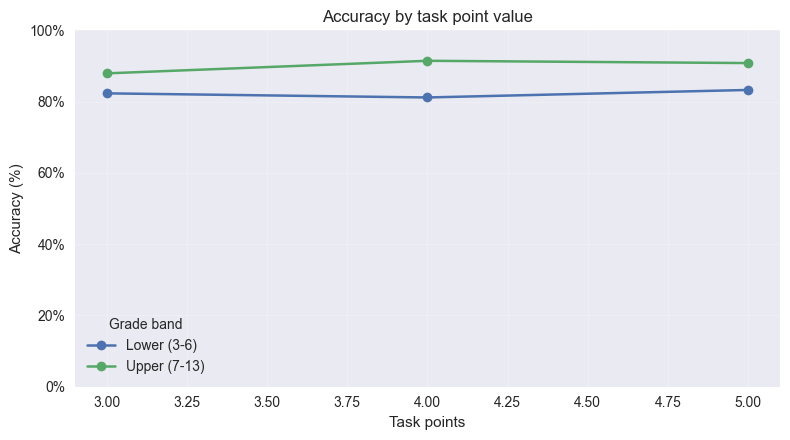

In [267]:
# Accuracy vs point value per grade band
import score_utils

def _infer_primary_grade(group_label):
    numbers = score_utils.extract_grade_numbers(group_label)
    return min(numbers) if numbers else None

def _infer_grade_band(group_label):
    grade = _infer_primary_grade(group_label)
    if grade is None:
        return 'Unknown'
    if 3 <= grade <= 6:
        return 'Lower (3-6)'
    if 7 <= grade <= 13:
        return 'Upper (7-13)'
    return 'Other'

question_stats = df[df['attempted']].copy()
question_stats['points'] = pd.to_numeric(question_stats['points'], errors='coerce')
question_stats['problem_number_num'] = pd.to_numeric(question_stats['problem_number'], errors='coerce')
question_stats['grade_band'] = question_stats['group'].apply(_infer_grade_band)

points_summary = (
    question_stats.dropna(subset=['points'])
    .groupby(['grade_band', 'points'])['answered_correctly']
    .mean()
    .reset_index()
)

if points_summary.empty:
    print('No point-based accuracy data available.')
else:
    fig, ax = plt.subplots(figsize=(8, 4.5))
    for band, subset in points_summary.groupby('grade_band'):
        ax.plot(
            subset['points'],
            subset['answered_correctly'] * 100,
            marker='o',
            linewidth=1.8,
            label=band,
        )
    ax.set_xlabel('Task points')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Accuracy by task point value')
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter())
    ax.grid(alpha=0.2)
    ax.legend(title='Grade band', loc='lower left')
    plt.tight_layout()

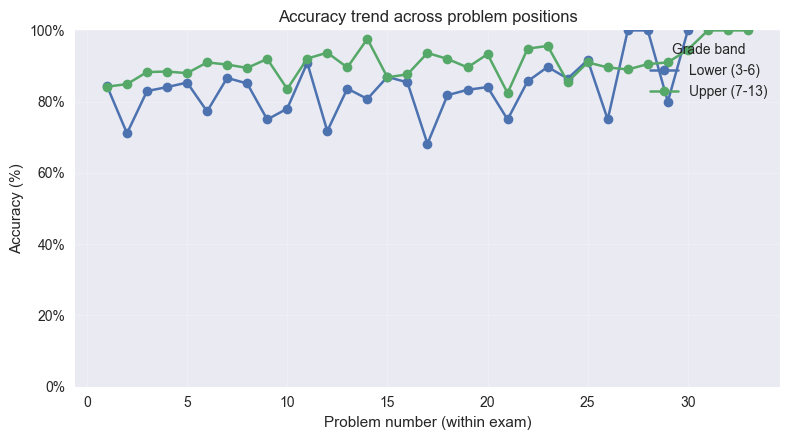

In [268]:
# Accuracy vs problem position
position_summary = (
    question_stats.dropna(subset=['problem_number_num'])
    .groupby(['grade_band', 'problem_number_num'])['answered_correctly']
    .mean()
    .reset_index()
)

if position_summary.empty:
    print('No problem position data available.')
else:
    fig, ax = plt.subplots(figsize=(8, 4.5))
    for band, subset in position_summary.groupby('grade_band'):
        subset = subset.sort_values('problem_number_num')
        ax.plot(
            subset['problem_number_num'],
            subset['answered_correctly'] * 100,
            marker='o',
            linewidth=1.8,
            label=band,
        )
    ax.set_xlabel('Problem number (within exam)')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Accuracy trend across problem positions')
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter())
    ax.grid(alpha=0.2)
    ax.legend(title='Grade band', loc='upper right')
    plt.tight_layout()

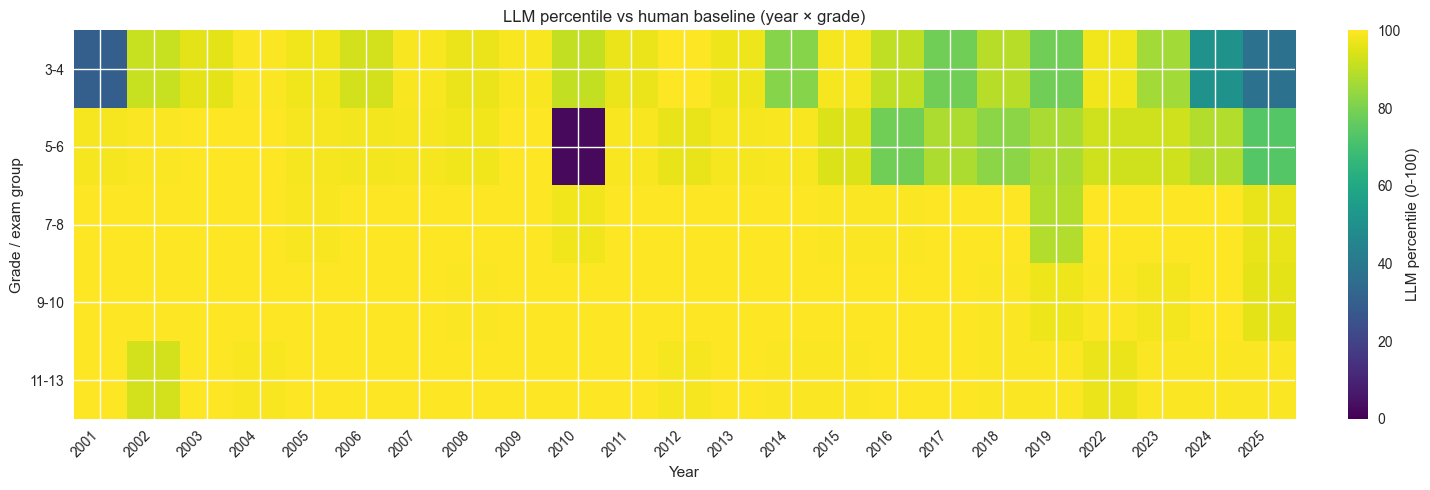

In [269]:
# Heatmap of LLM percentile by year and grade
if comparison_df.empty:
    print('No human comparison data available for heatmap.')
else:
    heatmap_df = comparison_df.copy()
    heatmap_df['year'] = heatmap_df['year'].astype(int)
    heatmap_df['exam'] = heatmap_df['exam'].astype(str)

    pivot = heatmap_df.pivot_table(
        index='exam',
        columns='year',
        values='llm_percentile',
        aggfunc='mean'
    )

    if pivot.empty:
        print('Heatmap pivot is empty.')
    else:
        def _heatmap_sort_key(label):
            nums = score_utils.extract_grade_numbers(label)
            return (min(nums) if nums else 99, label)

        pivot = pivot.reindex(sorted(pivot.index, key=_heatmap_sort_key))
        year_order = sorted(pivot.columns)
        pivot = pivot[year_order]

        data = pivot.to_numpy(dtype=float)
        mask = np.isnan(data)
        data_masked = np.ma.masked_array(data, mask=mask)

        fig_width = max(8, 0.5 * len(year_order) + 3)
        fig_height = max(5, 0.4 * len(pivot.index) + 2)
        fig, ax = plt.subplots(figsize=(fig_width, fig_height))
        cmap = plt.cm.viridis
        cmap.set_bad(color='lightgray')
        im = ax.imshow(data_masked, aspect='auto', cmap=cmap, vmin=0, vmax=100)

        ax.set_xticks(range(len(year_order)))
        ax.set_xticklabels(year_order, rotation=45, ha='right')
        ax.set_yticks(range(len(pivot.index)))
        ax.set_yticklabels(pivot.index)
        ax.set_xlabel('Year')
        ax.set_ylabel('Grade / exam group')
        ax.set_title('LLM percentile vs human baseline (year × grade)')

        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('LLM percentile (0-100)')
        plt.tight_layout()


In [270]:
# Human CDF overlay with LLM score
from typing import Optional

def plot_human_cdf_with_llm(year: int, exam_id: str, *, ax: Optional[plt.Axes] = None) -> Optional[plt.Axes]:
    year = int(year)
    exam_id = str(exam_id)
    human_stats = resolve_human_stats(year, exam_id)
    if not human_stats or human_stats.get('counts') is None:
        print(f'No human distribution data for {year} {exam_id}.')
        return None

    counts = np.asarray(human_stats.get('counts'), dtype=float)
    midpoints = np.asarray(human_stats.get('bin_midpoints'), dtype=float)
    valid_mask = (~np.isnan(counts)) & (~np.isnan(midpoints))
    if valid_mask.sum() == 0:
        print(f'No valid bins to plot for {year} {exam_id}.')
        return None

    scores = midpoints[valid_mask]
    counts = counts[valid_mask]
    order = np.argsort(scores)
    scores = scores[order]
    counts = counts[order]

    cumulative = np.cumsum(counts)
    total = cumulative[-1]
    if total <= 0:
        print(f'Empty human distribution for {year} {exam_id}.')
        return None
    cdf = cumulative / total

    target_ax = ax or plt.subplots(figsize=(7.5, 4.5))[1]
    target_ax.step(scores, cdf, where='post', linewidth=2.2, label='Human CDF')

    row = comparison_df[(comparison_df['year'] == year) & (comparison_df['exam'] == exam_id)]
    if row.empty:
        target_ax.set_title(f'{year} {exam_id}: human CDF (LLM score unavailable)')
    else:
        row = row.iloc[0]
        llm_score = float(row['llm_score']) if pd.notna(row['llm_score']) else None
        llm_max = float(row['llm_max']) if pd.notna(row['llm_max']) else None
        human_max = human_stats.get('max_points')
        if human_max and llm_score is not None and llm_max and human_max != llm_max and llm_max != 0:
            llm_scaled = llm_score / llm_max * human_max
        else:
            llm_scaled = llm_score

        percentile = None
        if llm_scaled is not None:
            percentile = percentile_from_distribution(
                llm_scaled,
                human_stats.get('counts'),
                human_stats.get('bins'),
                human_stats.get('bin_midpoints')
            )
            target_ax.axvline(llm_scaled, color='tab:red', linestyle='--', linewidth=1.8,
                              label=f'LLM score ({percentile:.1f}th pct)' if percentile is not None else 'LLM score')
            if percentile is not None:
                target_ax.axhline(percentile / 100, color='tab:red', linestyle=':', linewidth=1.5)
                target_ax.text(
                    llm_scaled,
                    percentile / 100,
                    f'  {percentile:.1f}%',
                    color='tab:red',
                    va='bottom'
                )
        title_pct = f' – {percentile:.1f}th pct' if percentile is not None else ''
        target_ax.set_title(f'{year} {exam_id}: human CDF vs LLM score{title_pct}')

    target_ax.set_xlabel('Score (scaled to human maximum)')
    target_ax.set_ylabel('Cumulative share of students (≤ score)')
    target_ax.set_ylim(0, 1.02)
    target_ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    target_ax.grid(alpha=0.2)
    target_ax.legend()
    if ax is None:
        plt.tight_layout()
    return target_ax


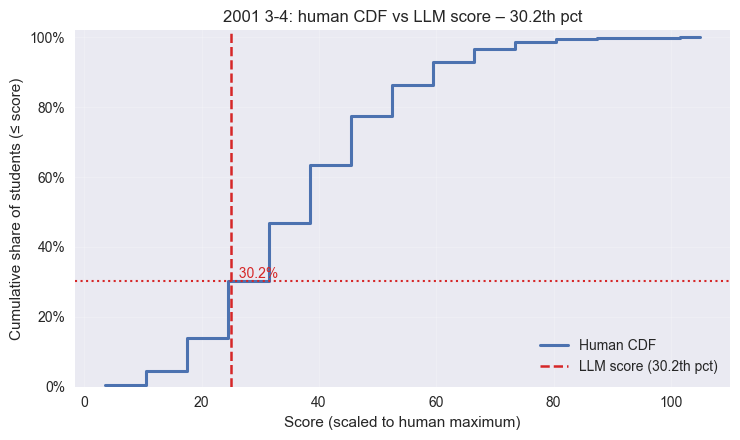

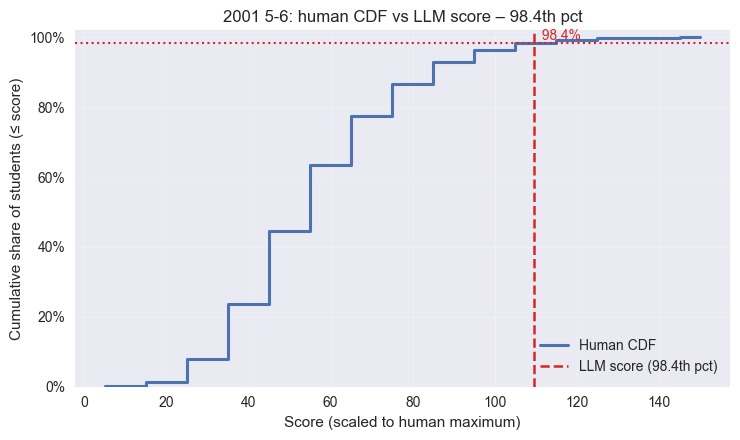

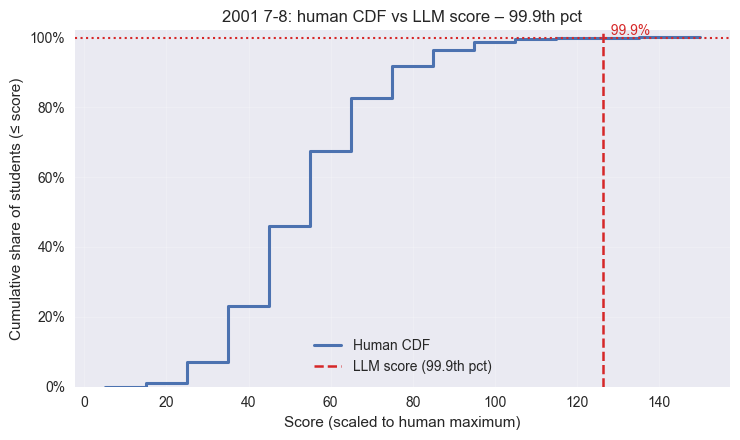

In [271]:
# Example CDF plots for first available exams
if comparison_df.empty:
    print('No LLM-human comparisons available for CDF plots.')
else:
    sample_pairs = comparison_df[['year', 'exam']].drop_duplicates().head(3)
    for _, row in sample_pairs.iterrows():
        plot_human_cdf_with_llm(int(row['year']), str(row['exam']))


/var/folders/49/b5vrbq2n2w7_v77gnnpj8h7c0000gn/T/ipykernel_36368/3958198970.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = scatter_df.groupby(bins).agg(


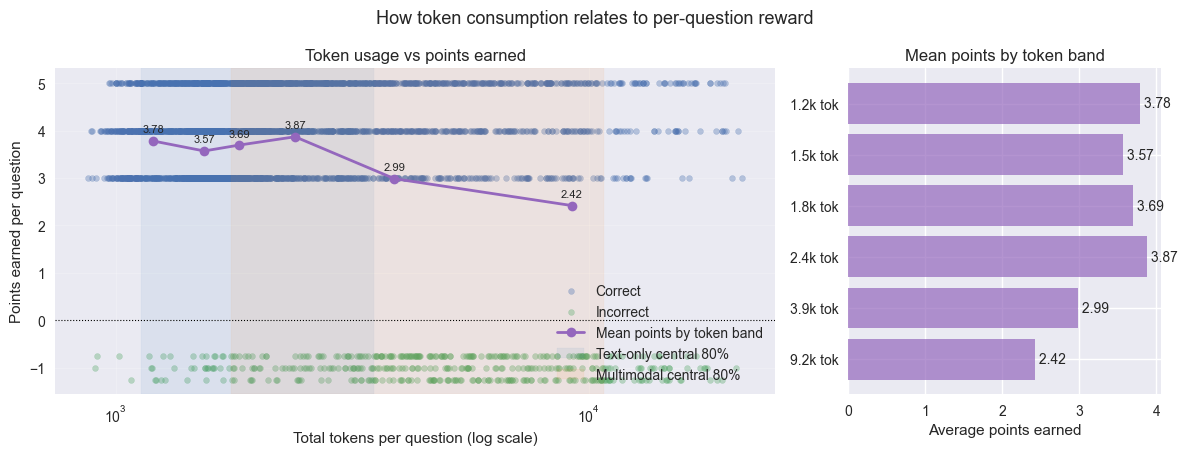

In [272]:
# Token usage vs points earned with bin summaries
required_columns = {'total_tokens', 'points_earned'}
if not required_columns.issubset(question_stats.columns):
    print('Token usage columns missing from dataset.')
else:
    scatter_df = question_stats.dropna(subset=['total_tokens', 'points_earned']).copy()
    if scatter_df.empty:
        print('No token usage data available for scatter plot.')
    else:
        scatter_df['correctness'] = np.where(scatter_df['answered_correctly'], 'Correct', 'Incorrect')
        scatter_df['token_bucket'] = np.where(scatter_df['multimodal'], 'Multimodal', 'Text-only')

        # Bin questions by total tokens (quantiles) to summarise efficiency across usage ranges
        bins = pd.qcut(scatter_df['total_tokens'], q=6, duplicates='drop')
        summary = scatter_df.groupby(bins).agg(
            mean_tokens=('total_tokens', 'mean'),
            median_tokens=('total_tokens', 'median'),
            mean_points=('points_earned', 'mean'),
            count=('points_earned', 'size'),
        ).reset_index(drop=True)
        summary['tokens_per_1k'] = summary['mean_tokens'] / 1000.0

        fig, axes = plt.subplots(1, 2, figsize=(12, 4.6), gridspec_kw={'width_ratios': [2.3, 1]})

        # Scatter plot with log-scale x-axis (captures large spread in usage)
        ax = axes[0]
        for label, subset in scatter_df.groupby('correctness'):
            ax.scatter(
                subset['total_tokens'],
                subset['points_earned'],
                s=18,
                alpha=0.35,
                label=label,
            )
        ax.set_xscale('log')
        ax.set_xlabel('Total tokens per question (log scale)')
        ax.set_ylabel('Points earned per question')
        ax.set_title('Token usage vs points earned')
        ax.axhline(0, color='black', linewidth=0.8, linestyle=':')
        ax.grid(alpha=0.2)

        if not summary.empty:
            ax.plot(
                summary['mean_tokens'],
                summary['mean_points'],
                color='tab:purple',
                marker='o',
                linewidth=2,
                label='Mean points by token band',
            )
            for _, row in summary.iterrows():
                ax.annotate(
                    f"{row['mean_points']:.2f}",
                    (row['mean_tokens'], row['mean_points']),
                    textcoords='offset points',
                    xytext=(0, 6),
                    ha='center',
                    fontsize=8,
                )

        # Highlight typical token ranges (central 80%) for text-only vs multimodal items
        text_tokens = scatter_df.loc[scatter_df['token_bucket'] == 'Text-only', 'total_tokens']
        vision_tokens = scatter_df.loc[scatter_df['token_bucket'] == 'Multimodal', 'total_tokens']
        if not text_tokens.empty:
            ax.axvspan(text_tokens.quantile(0.1), text_tokens.quantile(0.9), color='tab:blue', alpha=0.08, label='Text-only central 80%')
        if not vision_tokens.empty:
            ax.axvspan(vision_tokens.quantile(0.1), vision_tokens.quantile(0.9), color='tab:orange', alpha=0.08, label='Multimodal central 80%')

        ax.legend(loc='lower right')

        # Summary panel: mean points for each token band (helps interpret the scatter)
        ax2 = axes[1]
        if summary.empty:
            ax2.text(0.5, 0.5, 'Insufficient data for summary bins', ha='center', va='center')
            ax2.axis('off')
        else:
            ax2.barh(
                range(len(summary)),
                summary['mean_points'],
                color='tab:purple',
                alpha=0.7,
            )
            ax2.set_yticks(range(len(summary)))
            labels = [f"{row['tokens_per_1k']:.1f}k tok" for _, row in summary.iterrows()]
            ax2.set_yticklabels(labels)
            ax2.set_xlabel('Average points earned')
            ax2.set_title('Mean points by token band')
            for idx, row in summary.iterrows():
                ax2.text(row['mean_points'], idx, f" {row['mean_points']:.2f}", va='center')
            ax2.invert_yaxis()
        fig.suptitle('How token consumption relates to per-question reward', fontsize=13)
        plt.tight_layout()

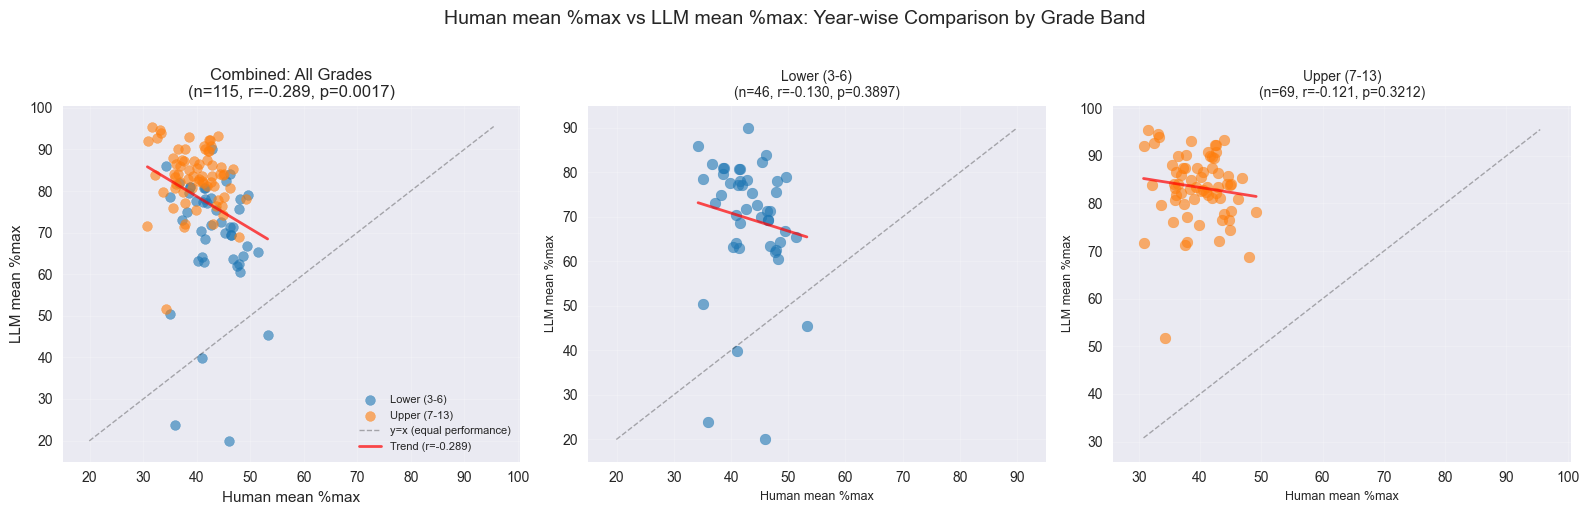


CORRELATION ANALYSIS: Human mean %max vs LLM mean %max

Overall correlation (all grades):
  Pearson r = -0.2891
  p-value = 0.001727
  Sample size = 115
  Regression: y = -0.7723x + 109.5942

Correlation by grade band:

  Lower (3-6):
    Pearson r = -0.1299
    p-value = 0.389662
    Sample size = 46
    Regression: y = -0.4043x + 87.0202

  Upper (7-13):
    Pearson r = -0.1212
    p-value = 0.321206
    Sample size = 69
    Regression: y = -0.2051x + 91.5393



In [273]:
# Year-wise scatter: Human mean %max vs LLM mean %max per grade
# %max = percentage of maximum points scored

if comparison_df.empty:
    print('No comparison data available for scatter plot.')
else:
    # Prepare the data
    scatter_data = comparison_df.copy()
    
    # Ensure we have both human_pct and llm_pct
    scatter_data = scatter_data.dropna(subset=['human_pct', 'llm_pct'])
    
    if scatter_data.empty:
        print('No data with both human and LLM percentages available.')
    else:
        # Extract grade band for color coding
        scatter_data['grade_band'] = scatter_data['exam'].apply(_infer_grade_band)
        
        # Create figure with subplots for each grade band
        grade_bands = scatter_data['grade_band'].unique()
        n_bands = len(grade_bands)
        
        # Create a single combined plot and separate plots by grade band
        fig = plt.figure(figsize=(16, 5))
        
        # Combined plot
        ax_combined = plt.subplot(1, n_bands + 1, 1)
        
        colors = {'Lower (3-6)': 'tab:blue', 'Upper (7-13)': 'tab:orange', 'Other': 'tab:green', 'Unknown': 'tab:gray'}
        
        for band in grade_bands:
            band_data = scatter_data[scatter_data['grade_band'] == band]
            ax_combined.scatter(
                band_data['human_pct'],
                band_data['llm_pct'],
                s=50,
                alpha=0.6,
                color=colors.get(band, 'tab:gray'),
                label=band
            )
        
        # Add diagonal reference line (y = x, where LLM = Human)
        max_val = max(scatter_data['human_pct'].max(), scatter_data['llm_pct'].max())
        min_val = min(scatter_data['human_pct'].min(), scatter_data['llm_pct'].min())
        ax_combined.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, linewidth=1, label='y=x (equal performance)')
        
        # Calculate overall trend line and correlation
        from scipy import stats
        x = scatter_data['human_pct'].values
        y = scatter_data['llm_pct'].values
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        
        # Plot trend line
        x_trend = np.linspace(x.min(), x.max(), 100)
        y_trend = slope * x_trend + intercept
        ax_combined.plot(x_trend, y_trend, 'r-', linewidth=2, alpha=0.7, label=f'Trend (r={r_value:.3f})')
        
        ax_combined.set_xlabel('Human mean %max')
        ax_combined.set_ylabel('LLM mean %max')
        ax_combined.set_title(f'Combined: All Grades\n(n={len(scatter_data)}, r={r_value:.3f}, p={p_value:.4f})')
        ax_combined.grid(alpha=0.2)
        ax_combined.legend(loc='best', fontsize=8)
        ax_combined.set_xlim(min_val - 5, max_val + 5)
        ax_combined.set_ylim(min_val - 5, max_val + 5)
        
        # Individual plots by grade band
        for idx, band in enumerate(sorted(grade_bands), start=2):
            ax = plt.subplot(1, n_bands + 1, idx)
            band_data = scatter_data[scatter_data['grade_band'] == band]
            
            ax.scatter(
                band_data['human_pct'],
                band_data['llm_pct'],
                s=60,
                alpha=0.6,
                color=colors.get(band, 'tab:gray')
            )
            
            # Add diagonal reference line
            band_max = max(band_data['human_pct'].max(), band_data['llm_pct'].max())
            band_min = min(band_data['human_pct'].min(), band_data['llm_pct'].min())
            ax.plot([band_min, band_max], [band_min, band_max], 'k--', alpha=0.3, linewidth=1)
            
            # Calculate band-specific trend line and correlation
            if len(band_data) > 2:
                x_band = band_data['human_pct'].values
                y_band = band_data['llm_pct'].values
                slope_b, intercept_b, r_value_b, p_value_b, std_err_b = stats.linregress(x_band, y_band)
                
                # Plot trend line
                x_trend_b = np.linspace(x_band.min(), x_band.max(), 100)
                y_trend_b = slope_b * x_trend_b + intercept_b
                ax.plot(x_trend_b, y_trend_b, 'r-', linewidth=2, alpha=0.7)
                
                ax.set_title(f'{band}\n(n={len(band_data)}, r={r_value_b:.3f}, p={p_value_b:.4f})', fontsize=10)
            else:
                ax.set_title(f'{band}\n(n={len(band_data)}, insufficient data)', fontsize=10)
            
            ax.set_xlabel('Human mean %max', fontsize=9)
            ax.set_ylabel('LLM mean %max', fontsize=9)
            ax.grid(alpha=0.2)
            ax.set_xlim(band_min - 5, band_max + 5)
            ax.set_ylim(band_min - 5, band_max + 5)
        
        plt.suptitle('Human mean %max vs LLM mean %max: Year-wise Comparison by Grade Band', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()
        
        # Print correlation statistics
        print("\n" + "=" * 80)
        print("CORRELATION ANALYSIS: Human mean %max vs LLM mean %max")
        print("=" * 80)
        print(f"\nOverall correlation (all grades):")
        print(f"  Pearson r = {r_value:.4f}")
        print(f"  p-value = {p_value:.6f}")
        print(f"  Sample size = {len(scatter_data)}")
        print(f"  Regression: y = {slope:.4f}x + {intercept:.4f}")
        
        print("\nCorrelation by grade band:")
        for band in sorted(grade_bands):
            band_data = scatter_data[scatter_data['grade_band'] == band]
            if len(band_data) > 2:
                x_band = band_data['human_pct'].values
                y_band = band_data['llm_pct'].values
                slope_b, intercept_b, r_value_b, p_value_b, std_err_b = stats.linregress(x_band, y_band)
                print(f"\n  {band}:")
                print(f"    Pearson r = {r_value_b:.4f}")
                print(f"    p-value = {p_value_b:.6f}")
                print(f"    Sample size = {len(band_data)}")
                print(f"    Regression: y = {slope_b:.4f}x + {intercept_b:.4f}")
            else:
                print(f"\n  {band}:")
                print(f"    Sample size = {len(band_data)} (insufficient for correlation)")
        
        print("\n" + "=" * 80)


,group,n,r,slope,Δmean_pp,Δmedian_pp
0,Overall,115,-0.289,-0.108,-36.78,-39.34
1,Lower (3-6),46,-0.130,-0.042,-26.41,-28.64
2,Upper (7-13),69,-0.121,-0.072,-43.70,-44.66


Note: lower LLM %max implies harder exam; Δ > 0 means humans > LLM.


/var/folders/49/b5vrbq2n2w7_v77gnnpj8h7c0000gn/T/ipykernel_36368/2494165841.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(bp_data, vert=True, labels=[b.replace(' (','(') for b in plot_bands], patch_artist=True, boxprops=dict(facecolor='lightgray', alpha=0.6))


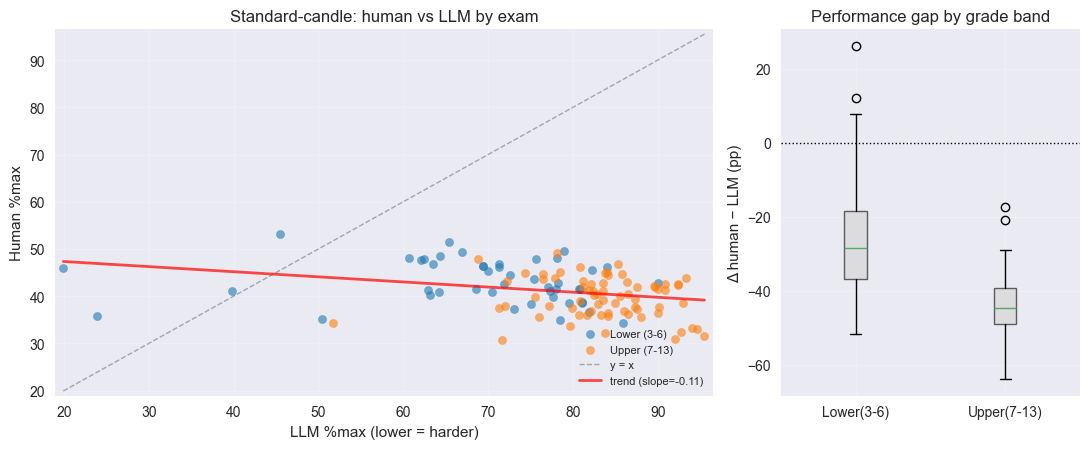

In [274]:

# Standard-Candle: Humans vs LLM-derived difficulty (refined)
# Compact summary table + concise visual (scatter + boxplot).
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import score_utils

def _grade_band(exam_id):
    nums = score_utils.extract_grade_numbers(exam_id)
    g = min(nums) if nums else None
    if g is None: return 'Unknown'
    return 'Lower (3-6)' if 3 <= g <= 6 else ('Upper (7-13)' if 7 <= g <= 13 else 'Other')

if 'comparison_df' not in globals() or comparison_df.empty:
    print('Standard-candle: skipped (no aligned human/LLM data).')
else:
    data = comparison_df.dropna(subset=['human_pct','llm_pct']).copy()
    if data.empty:
        print('Standard-candle: skipped (insufficient data).')
    else:
        data['grade_band'] = data['exam'].apply(_grade_band)
        data['delta_pp'] = data['human_pct'] - data['llm_pct']

        def _stats(df):
            x = df['llm_pct'].to_numpy(); y = df['human_pct'].to_numpy(); n = len(df)
            if n > 1:
                r = float(np.corrcoef(x, y)[0,1]); slope, intercept = np.polyfit(x, y, 1)
            else:
                r, slope, intercept = np.nan, np.nan, np.nan
            return {'n': n, 'r': r, 'slope': slope, 'Δmean_pp': df['delta_pp'].mean(), 'Δmedian_pp': df['delta_pp'].median()}

        rows = [{'group': 'Overall', **_stats(data)}]
        for band, g in data.groupby('grade_band'):
            rows.append({'group': band, **_stats(g)})
        summary = pd.DataFrame(rows)
        for col in ['r','slope','Δmean_pp','Δmedian_pp']:
            summary[col] = summary[col].round(3 if col in ('r','slope') else 2)
        display(summary[['group','n','r','slope','Δmean_pp','Δmedian_pp']])

        # Visual: scatter (LLM vs Human) + boxplot of Δ by grade band
        bands = ['Lower (3-6)','Upper (7-13)','Other','Unknown']
        colors = {'Lower (3-6)':'tab:blue','Upper (7-13)':'tab:orange','Other':'tab:green','Unknown':'tab:gray'}
        fig, axes = plt.subplots(1, 2, figsize=(11, 4.6), gridspec_kw={'width_ratios': [2.2, 1]})
        ax = axes[0]
        for b in bands:
            sub = data[data['grade_band'] == b]
            if sub.empty: continue
            ax.scatter(sub['llm_pct'], sub['human_pct'], s=35, alpha=0.6, label=b, color=colors.get(b,'tab:gray'))
        mn = min(data['llm_pct'].min(), data['human_pct'].min()); mx = max(data['llm_pct'].max(), data['human_pct'].max())
        ax.plot([mn, mx], [mn, mx], 'k--', linewidth=1, alpha=0.3, label='y = x')
        x = data['llm_pct'].to_numpy(); y = data['human_pct'].to_numpy()
        if len(x) > 1:
            slope, intercept = np.polyfit(x, y, 1); xline = np.linspace(mn, mx, 100)
            ax.plot(xline, slope*xline + intercept, 'r-', linewidth=2, alpha=0.7, label=f'trend (slope={slope:.2f})')
        ax.set_xlabel('LLM %max (lower = harder)')
        ax.set_ylabel('Human %max')
        ax.set_title('Standard-candle: human vs LLM by exam')
        ax.grid(alpha=0.2); ax.legend(loc='lower right', fontsize=8)
        ax.set_xlim(mn-1, mx+1); ax.set_ylim(mn-1, mx+1)

        ax2 = axes[1]
        plot_bands = [b for b in bands if not data[data['grade_band'] == b].empty]
        bp_data = [data.loc[data['grade_band'] == b, 'delta_pp'] for b in plot_bands]
        ax2.boxplot(bp_data, vert=True, labels=[b.replace(' (','(') for b in plot_bands], patch_artist=True, boxprops=dict(facecolor='lightgray', alpha=0.6))
        ax2.axhline(0, color='k', linestyle=':', linewidth=1)
        ax2.set_ylabel('Δ human − LLM (pp)')
        ax2.set_title('Performance gap by grade band')
        ax2.grid(alpha=0.2)
        plt.tight_layout()

        print('Note: lower LLM %max implies harder exam; Δ > 0 means humans > LLM.')
